Lo primero que debemos hacer es filtar todos los datos que necesitamos

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ecgdetectors import Detectors
import neurokit2 as nk
import scipy.stats as stats
import seaborn as sns

datos = pd.read_excel(r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\Diagnostics.xlsx')
copydatos= datos

In [28]:
AFIB = datos[datos["Rhythm"] == 'AFIB']
SB = datos[datos["Rhythm"] == 'SB']
SR = datos[datos["Rhythm"] == 'SR']
ST = datos[datos["Rhythm"] == 'ST']
AF = datos[datos["Rhythm"] == 'AF']
SA = datos[datos["Rhythm"] == 'SA']
SVT = datos[datos["Rhythm"] == 'SVT']
AT = datos[datos["Rhythm"] == 'AT']


El primer paso es limpiar todos los valores outliers, haremos dos pasadas y comprobaremos haciendo la grafica de boxplot

In [29]:
def filtrar_outliers(df):
    df_filtrado = pd.DataFrame()
    for tipo in df['Rhythm'].unique():
        subset = df[df['Rhythm'] == tipo]
        Q1 = subset['PatientAge'].quantile(0.25)
        Q3 = subset['PatientAge'].quantile(0.75)
        IQR = Q3 - Q1
        # Filtrar valores dentro del rango aceptable
        filtro = (subset['PatientAge'] >= Q1 - 1.5 * IQR) & (subset['PatientAge'] <= Q3 + 1.5 * IQR)
        df_filtrado = pd.concat([df_filtrado, subset[filtro]], axis=0)
    return df_filtrado

The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR. In a boxplot, the highest and lowest occurring value within this limit are indicated by whiskers of the box (frequently with an additional bar at the end of the whisker) and any outliers as individual points.

Referencia https://en.wikipedia.org/wiki/Interquartile_range

In [30]:
limpiav1= filtrar_outliers(copydatos)
limpiav2= filtrar_outliers(limpiav1)

C:\Users\ctama\AppData\Local\Temp\ipykernel_43120\2558886903.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=limpiav2, x='Rhythm', y='PatientAge', palette='pastel')


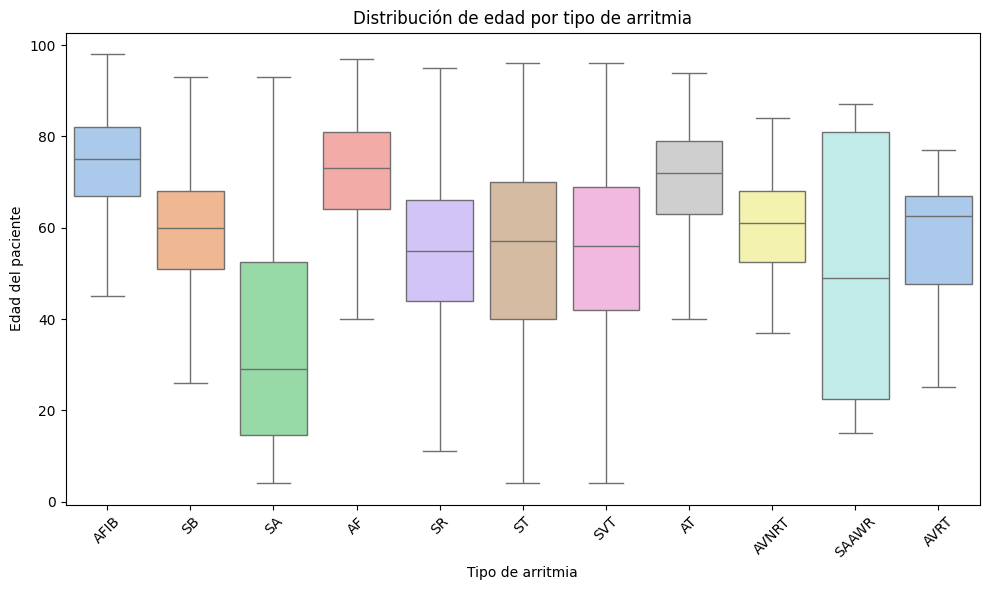

In [31]:
#3 Arritmias más prevalentes según edad

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
limpiav2['AgeGroup'] = pd.cut(limpiav2['PatientAge'], bins=bins, labels=labels)

# Boxplot de edad por tipo de arritmia
plt.figure(figsize=(10, 6))
sns.boxplot(data=limpiav2, x='Rhythm', y='PatientAge', palette='pastel')
plt.title("Distribución de edad por tipo de arritmia")
plt.xlabel("Tipo de arritmia")
plt.ylabel("Edad del paciente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Siguiendo las intrucciones del primer analisis, seleccionamos las arritmias y descartamos las demas, y aparte mantenemos el rango de edad entrer 20 y 80 años

In [32]:
arritmias_permitidas = ['SB', 'SR', 'ST', 'AFIB', 'SVT', 'AF', 'SA', 'AT']

# Filtrar el DataFrame
df_filtrado = limpiav2[
    (limpiav2['Rhythm'].isin(arritmias_permitidas)) &
    (limpiav2['PatientAge'] >= 20) &
    (limpiav2['PatientAge'] <= 80)
].copy()

In [33]:
df_filtrado

FileName Rhythm           Beat  PatientAge  Gender  \
6      MUSE_20180114_075026_69000   AFIB            TWC          80  FEMALE   
15     MUSE_20180113_133901_16000   AFIB           STTC          67  FEMALE   
35     MUSE_20180113_074740_85000   AFIB           NONE          74  FEMALE   
37     MUSE_20180114_132044_36000   AFIB       LVHV VPB          71    MALE   
39     MUSE_20180116_131337_59000   AFIB           NONE          77    MALE   
...                           ...    ...            ...         ...     ...   
10257  MUSE_20180118_180414_04000     AT        APB IDC          60  FEMALE   
10273  MUSE_20180119_174304_25000     AT        LVQRSCL          64    MALE   
10274  MUSE_20180119_174306_34000     AT        LVQRSCL          64    MALE   
10275  MUSE_20180119_174507_54000     AT            PWC          70    MALE   
10288  MUSE_20180120_122726_72000     AT  STDD STTC TWO          74  FEMALE   

       VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  \
6                   98          86           74         360          459   
15                  72          65           90         416          455   
35                  90          77           80         356          435   
37                 115          97           84         324          448   
39                  94         267           70         338          422   
...                ...         ...          ...         ...          ...   
10257              137         315          104         336          507   
10273               87          87           82         378          454   
10274               91         110           88         344          423   
10275               79          98           84         346          396   
10288              127         170           88         360          523   

       RAxis  TAxis  QRSCount  QOnset  QOffset  TOffset AgeGroup  
6         69     83        17     215      252      395    61-80  
15        -1    -15        12     228      273      436    61-80  
35        42      7        15     229      269      407    61-80  
37        34     39        19     227      269      389    61-80  
39        39     37        15     224      259      393    61-80  
...      ...    ...       ...     ...      ...      ...      ...  
10257     22     43        22     214      266      382    41-60  
10273     65     59        14     221      262      410    61-80  
10274     56     37        15     220      264      392    61-80  
10275     72     70        13     222      264      395    61-80  
10288      0    -28        21     224      268      404    61-80  

[9034 rows x 17 columns]

Trabajaremos con los datos de los dos generos, pero como se evidencio en el analisis 1, en ciertas arritmias existen mas cosas de un genero que el otro, se realiza un balanceo de datos, para evitar sesgos en el analisis.

In [34]:
def balancear_por_sexo_y_arritmia(df, columna_arritmia='Rhythm', columna_sexo='Gender'):
    df_balanceado = pd.DataFrame()

    for arritmia in df[columna_arritmia].unique():
        grupo = df[df[columna_arritmia] == arritmia]

        # Separar por sexo
        hombres = grupo[grupo[columna_sexo] == 'MALE']
        mujeres = grupo[grupo[columna_sexo] == 'FEMALE']

        # Determinar cuántos se pueden conservar (el mínimo entre ambos)
        n = min(len(hombres), len(mujeres))

        # Tomar muestra aleatoria estratificada (sin reemplazo)
        hombres_muestra = hombres.sample(n=n, random_state=42)
        mujeres_muestra = mujeres.sample(n=n, random_state=42)

        # Unir y añadir al DataFrame final
        df_balanceado = pd.concat([df_balanceado, hombres_muestra, mujeres_muestra], axis=0)

    return df_balanceado.reset_index(drop=True)

In [35]:
df_balanceado = balancear_por_sexo_y_arritmia(df_filtrado)
print(df_balanceado['Rhythm'].value_counts())
print(df_balanceado['Gender'].value_counts())

Rhythm
SB      2640
SR      1476
ST      1290
AFIB     992
SVT      488
AF       276
SA       236
AT        82
Name: count, dtype: int64
Gender
MALE      3740
FEMALE    3740
Name: count, dtype: int64


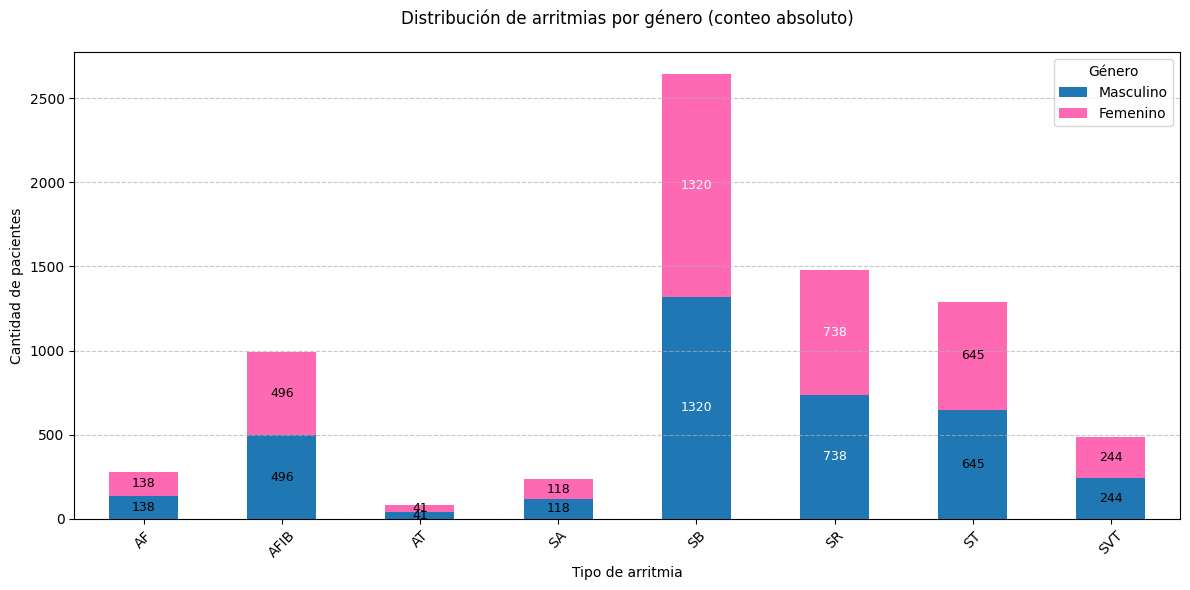

In [36]:
# Agrupar por tipo de arritmia y género
arrhythmia_by_gender = df_balanceado.groupby(['Rhythm', 'Gender']).size().unstack(fill_value=0)

# Reordenar columnas para que 'MALE' esté primero
arrhythmia_by_gender = arrhythmia_by_gender[['MALE', 'FEMALE']]

# Definir colores: azul para masculino, rosado para femenino
colors = ['#1f77b4', '#ff69b4']

# Crear gráfico de barras apiladas
ax = arrhythmia_by_gender.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Añadir etiquetas con los valores en cada segmento de barra
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:  # Solo mostrar etiquetas si hay valores
        x, y = p.get_xy() 
        ax.annotate(
            f'{int(height)}', 
            (x + width/2, y + height/2), 
            ha='center', 
            va='center',
            fontsize=9,
            color='white' if height > max(arrhythmia_by_gender.max())/2 else 'black'
        )

# Etiquetas y título
plt.title("Distribución de arritmias por género (conteo absoluto)", pad=20)
plt.xlabel("Tipo de arritmia")
plt.ylabel("Cantidad de pacientes")
plt.xticks(rotation=45)
plt.legend(title="Género", labels=["Masculino", "Femenino"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

for rhythm in arrhythmia_by_gender.index:
    total = arrhythmia_by_gender.loc[rhythm].sum()
    male_count = arrhythmia_by_gender.loc[rhythm, 'MALE']
    female_count = arrhythmia_by_gender.loc[rhythm, 'FEMALE']
    
    male_percent = (male_count / total) * 100
    female_percent = (female_count / total) * 100
    
    dominant = 'MASCULINO' if male_count > female_count else 'FEMENINO'
    dominance_ratio = max(male_count, female_count) / min(male_count, female_count) if min(male_count, female_count) > 0 else np.inf

Teniendo correctamente nuestros datos procesados, podemos empezar a calcular el pico R a cada arritmia

In [13]:
df_balanceado.columns

Index(['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate',
       'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis',
       'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset', 'AgeGroup'],
      dtype='object')

In [ ]:
df_balanceado

In [15]:
fs = 500  # Frecuencia de muestreo
r_peaks_lista = []

for nombre_archivo in df_balanceado['FileName']:
    try:
        # Ruta al archivo de ECG
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Usamos la derivación II
        ecg_signal = senal['II'].values

        # Detección de picos R con neurokit2
        _, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs, correct_artifacts=False, show=False)
        r_peaks_lista.append(info["ECG_R_Peaks"])

    except Exception as e:
        print(f"Error con archivo {nombre_archivo}: {e}")
        r_peaks_lista.append([])  # Si falla, guardar lista vacía

# Agregar columna al DataFrame
df_balanceado["R_Peaks"] = r_peaks_lista

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
df_balanceado

FileName Rhythm              Beat  PatientAge  Gender  \
0     MUSE_20180712_160452_75000   AFIB               LVH          74    MALE   
1     MUSE_20180118_131905_87000   AFIB               TWC          72    MALE   
2     MUSE_20180114_071444_05000   AFIB               TWC          74    MALE   
3     MUSE_20180114_132956_24000   AFIB          LVHV TWC          68    MALE   
4     MUSE_20180118_124852_18000   AFIB              STTU          78    MALE   
...                          ...    ...               ...         ...     ...   
7475  MUSE_20180114_124959_72000     AT         LVHV STDD          77  FEMALE   
7476  MUSE_20180113_134050_13000     AT              NONE          79  FEMALE   
7477  MUSE_20180114_071212_35000     AT         2AVB STTC          75  FEMALE   
7478  MUSE_20180115_123937_31000     AT              NONE          63  FEMALE   
7479  MUSE_20180118_175239_33000     AT  APB LVHV TWC VPB          64  FEMALE   

      VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  \
0                  49          57           92         488          440   
1                 151         170           84         298          472   
2                 107         108           82         342          456   
3                  95          87           84         334          419   
4                  97         153          104         344          436   
...               ...         ...          ...         ...          ...   
7475              110         110          106         310          419   
7476              109         109           72         350          471   
7477              143         156           74         328          506   
7478               99          99           76         348          446   
7479              127         129           88         286          415   

      RAxis  TAxis  QRSCount  QOnset  QOffset  TOffset AgeGroup  
0        64     70         7     221      267      465    61-80  
1       -13    176        25     210      252      359    61-80  
2        50     64        18     216      257      387    61-80  
3        45     18        16     228      270      395    61-80  
4       -29     29        16     221      273      393    61-80  
...     ...    ...       ...     ...      ...      ...      ...  
7475     43     53        18     219      272      374    61-80  
7476     22     -9        17     225      261      400    61-80  
7477     56    -13        24     219      256      383    61-80  
7478     53     43        16     225      263      399    61-80  
7479    -16    141        21     213      257      356    61-80  

[7480 rows x 17 columns]

In [38]:
df_balanceado.to_excel('resumido.xlsx', index=False, sheet_name='Datos')

In [16]:
df_balanceado.to_excel('DatosfiltradosconpicosR.xlsx', index=False, sheet_name='Datos')

In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. Selección del archivo ----------
# Simulación de selección por nombre_archivo(6)
archivos = [f"ECG_{i}.csv" for i in range(1, 11)]  # Puedes ajustar nombres
archivo = archivos[6]  # Seleccionamos el archivo en la posición 6

# ---------- 2. Cargar datos ECG ----------
# Asumiendo que hay una columna llamada 'ECG' en el CSV
data = pd.read_csv(archivo)
ecg_signal = data["ECG"]  # Ajusta el nombre de columna si es diferente

# ---------- 3. Detectar picos R ----------
sampling_rate = 500  # Hz
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
signals, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)

# Obtener los tiempos RR en milisegundos
rpeaks = info["ECG_R_Peaks"]
rr_intervals = np.diff(rpeaks) * 1000 / sampling_rate  # En ms

# ---------- 4. Calcular SDNN y RMSSD con nk ----------
rr_sec = rr_intervals / 1000  # En segundos
hrv_metrics = nk.hrv(rr_sec, sampling_rate=1, show=False, metrics=["sdnn", "rmssd"])
sdnn = hrv_metrics["SDNN"].values[0]
rmssd = hrv_metrics["RMSSD"].values[0]

# ---------- 5. Calcular LF/HF manualmente con FFT ----------
# Convertir a tiempos acumulados
tiempo = np.cumsum(rr_sec)
frecuencias = np.fft.fftfreq(len(tiempo), d=1/sampling_rate)
espectro = np.abs(np.fft.fft(tiempo))**2

# Filtrar bandas
lf = np.logical_and(frecuencias >= 0.04, frecuencias <= 0.15)
hf = np.logical_and(frecuencias >= 0.15, frecuencias <= 0.4)

potencia_lf = np.sum(espectro[lf])
potencia_hf = np.sum(espectro[hf])

lf_hf = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

# ---------- 6. Mostrar resultados ----------
print(f"Archivo analizado: {archivo}")
print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"LF/HF: {lf_hf:.2f}")

Archivo procesado: MUSE_20180114_071444_05000
SDNN:  107.93 ms
RMSSD: 182.18 ms
LF/HF: nan


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


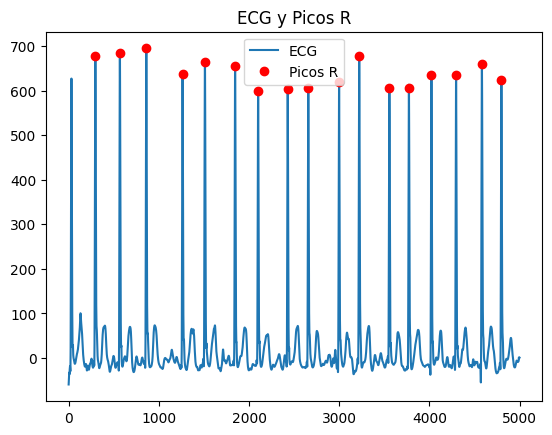

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Cargar lista de archivos desde un DataFrame (ejemplo) ===

# === Selección por índice ===
indice = 2  # Selecciona el índice que deseas
nombre_archivo = df_balanceado['FileName'][indice]
frecuencia_muestreo = 500

ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

# Verificar que existe la columna II
if "II" not in senal.columns:
    raise ValueError("La columna 'II' no existe en el archivo. Revisa el nombre.")

# Usamos la derivación II
ecg_signal = senal['II'].values

# === 2. Detectar picos R ===
ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
picos_r = info["ECG_R_Peaks"]


# === 3. Calcular intervalos RR (en segundos) ===
#rr_intervals = np.diff(picos_r) / frecuencia_muestreo

# === 4. Calcular SDNN y RMSSD ===
#hrv_metrics = nk.hrv(rr_intervals, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd"])
hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd"], show=False)
# metrics=["sdnn", "rmssd"]
sdnn = hrv_metrics["HRV_SDNN"].values[0]
rmssd = hrv_metrics["HRV_RMSSD"].values[0]
lf_hf = hrv_metrics["HRV_LFHF"].values[0]

# === 5. Calcular LF/HF con NumPy ===
#tiempos = np.cumsum(np.insert(rr_intervals, 0, 0))
#tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
#rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)
#frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
#espectro = np.abs(np.fft.fft(rr_interp))**2
#
#lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
#hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)
#
#potencia_lf = np.sum(espectro[lf_band])
#potencia_hf = np.sum(espectro[hf_band])
#
## ⚠️ Se evita división por cero
#lf_hf2 = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

# === 6. Resultados ===
print(f"Archivo procesado: {nombre_archivo}")
print(f"SDNN:  {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"LF/HF: {lf_hf:.2f}")
#print(f"LF/HF (numpy): {lf_hf2:.2f}")


# === 7. Graficar ECG con picos R ===
#plt.plot(ecg_signal, label="ECG")
#plt.plot(picos_r, ecg_signal[picos_r], "ro", label="Picos R")
#plt.legend()
#plt.title("ECG y Picos R")
#plt.show()

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Configuración ===
indice = 459  # Índice del archivo a procesar
nombre_archivo = df_balanceado['FileName'][indice]
frecuencia_muestreo = 500  # Hz

# === Cargar señal ECG ===
ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

# Verificar columna II
if "II" not in senal.columns:
    raise ValueError("La columna 'II' no existe en el archivo.")

# Usar derivación II
ecg_signal = senal['II'].values

# === Procesar ECG (sin gráficos automáticos) ===
ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
picos_r = info["ECG_R_Peaks"]

# === Calcular intervalos RR (necesarios para LF/HF con NumPy) ===
rr_intervals = np.diff(picos_r) / frecuencia_muestreo  # Convertir a segundos

# === Métricas HRV con NeuroKit2 ===
hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd", "lfhf"], show=False)
sdnn = hrv_metrics["HRV_SDNN"].values[0]
rmssd = hrv_metrics["HRV_RMSSD"].values[0]
lf_hf_nk = hrv_metrics["HRV_LFHF"].values[0]  # LF/HF de NeuroKit2

# === Cálculo de LF/HF con NumPy ===
# === 3. Calcular intervalos RR (en segundos) ===
rr_intervals = np.diff(picos_r) / frecuencia_muestreo  # Tiene N-1 elementos

# === Cálculo de LF/HF con NumPy ===
# 1. Tiempos acumulados de los picos R (sin el primer pico)
tiempos = np.cumsum(rr_intervals)  # Tiene N-1 elementos (como rr_intervals)

# 2. Interpolar (usar tiempos desde el primer intervalo RR en adelante)
tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)  # ¡Ahora las longitudes coinciden!

# 3. Transformada de Fourier
frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
espectro = np.abs(np.fft.fft(rr_interp))**2

# 4. Bandas de frecuencia
lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)

potencia_lf = np.sum(espectro[lf_band])
potencia_hf = np.sum(espectro[hf_band])

# 5. LF/HF (evitar división por cero)
lf_hf_numpy = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

# === Resultados ===
print(f"\nArchivo procesado: {nombre_archivo}")
print(f"SDNN (NeuroKit2): {sdnn:.2f} ms")
print(f"RMSSD (NeuroKit2): {rmssd:.2f} ms")
print(f"LF/HF (NeuroKit2): {lf_hf_nk:.2f}")
print(f"LF/HF (NumPy): {lf_hf_numpy:.2f}")




Archivo procesado: MUSE_20180114_065656_99000
SDNN (NeuroKit2): 58.33 ms
RMSSD (NeuroKit2): 54.99 ms
LF/HF (NeuroKit2): nan
LF/HF (NumPy): nan


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Frecuencia de muestreo fija ===
frecuencia_muestreo = 500  # Hz

# === Crear columnas vacías en el DataFrame si no existen ===
for col in ["SDNN", "RMSSD", "LFHF_NeuroKit", "LFHF_NumPy", "R_Peaks"]:
    if col not in df_balanceado.columns:
        df_balanceado[col] = np.nan

# === Procesar todos los archivos del DataFrame ===
for indice, nombre_archivo in enumerate(df_balanceado['FileName']):
    try:
        # Cargar archivo
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Verificar columna II
        if "II" not in senal.columns:
            print(f"❌ Archivo {nombre_archivo}: columna 'II' no encontrada.")
            continue

        ecg_signal = senal['II'].values

        # Procesar señal ECG
        ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
        picos_r = info["ECG_R_Peaks"]

        # HRV con NeuroKit2
        hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd", "lfhf"], show=False)
        sdnn = hrv_metrics["HRV_SDNN"].values[0]
        rmssd = hrv_metrics["HRV_RMSSD"].values[0]
        lf_hf_nk = hrv_metrics["HRV_LFHF"].values[0]

        # Cálculo manual de LF/HF
        rr_intervals = np.diff(picos_r) / frecuencia_muestreo
        if len(rr_intervals) < 2:
            raise ValueError("Muy pocos intervalos RR.")

        tiempos = np.cumsum(rr_intervals)
        tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
        rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)

        frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
        espectro = np.abs(np.fft.fft(rr_interp))**2

        lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
        hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)

        potencia_lf = np.sum(espectro[lf_band])
        potencia_hf = np.sum(espectro[hf_band])
        lf_hf_numpy = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

        # Guardar resultados
        df_balanceado.at[indice, "SDNN"] = sdnn
        df_balanceado.at[indice, "RMSSD"] = rmssd
        df_balanceado.at[indice, "LFHF_NeuroKit"] = lf_hf_nk
        df_balanceado.at[indice, "LFHF_NumPy"] = lf_hf_numpy
        df_balanceado.at[indice, "R_Peaks"] = [picos_r.tolist()]  # Guardar como lista

        print(f"✅ Procesado: {nombre_archivo}")

    except Exception as e:
        print(f"⚠️ Error en {nombre_archivo}: {e}")

In [14]:
df_balanceado.to_excel('DatosfiltradosconR.xlsx', index=False, sheet_name='Datos')

In [44]:
DatosFiltradosGrupo = pd.read_excel(r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Analisis 2\resumido.xlsx')

DatosFiltradosGrupo.head()

FileName Rhythm      Beat  PatientAge Gender  \
0  MUSE_20180712_160452_75000   AFIB       LVH          74   MALE   
1  MUSE_20180118_131905_87000   AFIB       TWC          72   MALE   
2  MUSE_20180114_071444_05000   AFIB       TWC          74   MALE   
3  MUSE_20180114_132956_24000   AFIB  LVHV TWC          68   MALE   
4  MUSE_20180118_124852_18000   AFIB      STTU          78   MALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0               49          57           92         488          440     64   
1              151         170           84         298          472    -13   
2              107         108           82         342          456     50   
3               95          87           84         334          419     45   
4               97         153          104         344          436    -29   

   TAxis  QRSCount  QOnset  QOffset  TOffset AgeGroup  
0     70         7     221      267      465    61-80  
1    176        25     210      252      359    61-80  
2     64        18     216      257      387    61-80  
3     18        16     228      270      395    61-80  
4     29        16     221      273      393    61-80

In [45]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Frecuencia de muestreo fija ===
frecuencia_muestreo = 500  # Hz

# === Crear columnas vacías en el DataFrame si no existen ===
for col in ["SDNN", "RMSSD", "LFHF_NeuroKit", "LFHF_NumPy", "R_Peaks"]:
    if col not in DatosFiltradosGrupo.columns:
        DatosFiltradosGrupo[col] = np.nan

# === Procesar todos los archivos del DataFrame ===
for indice, nombre_archivo in enumerate(DatosFiltradosGrupo['FileName']):
    try:
        # Cargar archivo
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Verificar columna II
        if "II" not in senal.columns:
            print(f"❌ Archivo {nombre_archivo}: columna 'II' no encontrada.")
            continue

        ecg_signal = senal['II'].values

        # Procesar señal ECG
        ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
        picos_r = info["ECG_R_Peaks"]

        # HRV con NeuroKit2
        hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd", "lfhf"], show=False)
        sdnn = hrv_metrics["HRV_SDNN"].values[0]
        rmssd = hrv_metrics["HRV_RMSSD"].values[0]
        lf_hf_nk = hrv_metrics["HRV_LFHF"].values[0]

        # Cálculo manual de LF/HF
        rr_intervals = np.diff(picos_r) / frecuencia_muestreo
        if len(rr_intervals) < 2:
            raise ValueError("Muy pocos intervalos RR.")

        tiempos = np.cumsum(rr_intervals)
        tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
        rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)

        frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
        espectro = np.abs(np.fft.fft(rr_interp))**2

        lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
        hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)

        potencia_lf = np.sum(espectro[lf_band])
        potencia_hf = np.sum(espectro[hf_band])
        lf_hf_numpy = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

        # Guardar resultados
        DatosFiltradosGrupo.at[indice, "SDNN"] = sdnn
        DatosFiltradosGrupo.at[indice, "RMSSD"] = rmssd
        DatosFiltradosGrupo.at[indice, "LFHF_NeuroKit"] = lf_hf_nk
        DatosFiltradosGrupo.at[indice, "LFHF_NumPy"] = lf_hf_numpy
        DatosFiltradosGrupo.at[indice, "R_Peaks"] = [picos_r.tolist()]  # Guardar como lista

        print(f"✅ Procesado: {nombre_archivo}")

    except Exception as e:
        print(f"⚠️ Error en {nombre_archivo}: {e}")

⚠️ Error en MUSE_20180712_160452_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_131905_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071444_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132956_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124852_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073251_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_171855_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130902_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133744_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120315_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_170450_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130101_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_125257_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_120935_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_065809_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132846_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115932_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134151_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180226_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_115828_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_121602_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_115323_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121851_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183412_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075050_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165358_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133612_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_071932_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131754_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124354_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124124_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073237_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131610_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121325_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_135335_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130120_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073333_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124224_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_124106_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133804_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_115706_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170910_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073035_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161225_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_115657_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123543_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130626_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134303_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_160541_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125907_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_132207_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123448_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182850_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_122832_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181143_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132107_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184119_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180111_170244_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125217_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120827_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170827_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_171955_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161247_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_172849_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160837_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135101_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120156_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131239_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132946_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184200_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180300_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_121236_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125618_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_073103_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124958_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_173630_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_120525_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122900_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160439_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171146_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120611_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132018_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132724_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161057_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182635_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_132044_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_180441_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125039_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_121039_40000: integer division or modulo by zero
⚠️ Error en MUSE_20180114_124930_50000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180112_124901_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132057_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132451_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124037_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121359_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_134519_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170911_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122519_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120111_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_125505_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170931_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_133437_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071043_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130723_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130210_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_120853_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074453_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135553_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131737_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123548_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_181402_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131452_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175313_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_130456_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122426_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_165653_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134601_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_171044_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170243_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133603_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_170239_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_134620_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120424_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183351_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120649_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_123723_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133022_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161449_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122741_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174405_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172319_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071044_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123158_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075442_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_073423_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_125619_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072002_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160516_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125719_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172704_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133230_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180111_170130_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123110_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_074103_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_114607_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133417_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130700_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073120_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181124_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131732_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134740_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130801_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_134134_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133558_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160448_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_165827_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_161309_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_133511_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065147_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174256_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132924_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165409_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_180416_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_161351_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_121348_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_173156_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135045_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171013_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174715_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_180035_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_130227_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132301_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133449_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130122_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172234_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075454_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180011_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_181843_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160449_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_125836_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170829_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122000_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_073749_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160141_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160901_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_123606_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171227_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122639_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130244_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_115609_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123534_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161505_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183759_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_134959_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072240_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124109_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140029_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115255_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160641_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121854_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132452_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132348_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121030_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161248_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133948_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125618_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174737_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182223_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133606_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133534_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121001_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_130702_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133117_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133427_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123749_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_160140_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132520_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171015_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123149_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_125458_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130651_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132313_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130844_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173315_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_182103_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075444_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160321_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122433_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123407_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_123056_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130337_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_123539_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134701_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121649_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_155925_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130756_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134836_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160301_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_123010_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130751_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_175406_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_181502_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_132202_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_114956_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121904_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130414_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_134539_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133158_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131040_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160300_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_171721_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073409_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175356_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160609_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161347_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181458_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_164231_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180230_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134255_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_122439_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174159_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_182031_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132337_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132441_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074345_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_124859_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_114902_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_123739_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_174456_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_161418_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_174430_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_133059_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_123724_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122711_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075458_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133057_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133130_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123353_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072824_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160446_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130638_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180118_135048_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120533_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132012_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123218_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_174714_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170139_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073230_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180012_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133928_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135820_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_133543_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_165602_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_071426_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121509_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180113_173215_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132340_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180101_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131403_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_125616_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123541_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_114634_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121731_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_122552_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_175357_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_171158_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_130038_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_180333_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134701_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_172930_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132044_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_120220_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125914_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173530_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133129_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_171008_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_115105_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161003_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120804_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_120038_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131757_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_074150_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065550_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125847_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170132_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120103_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134931_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171012_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132108_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_181355_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132901_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130502_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175231_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_071048_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120038_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131524_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130543_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125622_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135042_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174404_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_115329_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133611_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121227_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124636_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072928_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072726_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073126_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_181743_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131206_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180115_133535_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175028_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174854_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122542_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_160211_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171155_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180111_160715_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_114850_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174835_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180259_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_123622_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134509_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170445_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130751_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165410_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_125856_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_124939_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_131639_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_170829_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121343_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_132315_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074648_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180120_123754_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132007_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171024_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135928_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073047_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133423_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_132000_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135726_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_122943_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133409_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_181501_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180824_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124957_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_170754_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133110_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124941_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132022_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131251_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132403_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072345_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160426_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_130334_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175814_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161050_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_180440_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075518_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165702_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130643_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125845_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171448_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130022_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135158_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130305_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171628_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124625_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180228_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074543_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_130140_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_155949_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_130533_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074538_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_161355_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071342_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183723_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130539_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131218_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070940_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175418_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133420_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133112_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_163526_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180114_072142_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123105_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_123658_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123118_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072407_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123013_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_170307_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160522_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_161101_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_115515_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123927_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072907_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071047_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130935_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_071855_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_123601_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_123641_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132419_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_174429_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121742_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074133_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071829_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180227_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170708_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125425_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174946_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115852_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132347_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173519_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124056_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132229_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125946_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_065412_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182833_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125751_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180015_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075147_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065656_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121028_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_130638_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125506_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_163338_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130139_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_160241_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075014_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121819_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122740_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_132350_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124414_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160002_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122507_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175122_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184331_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_141151_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121238_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122740_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_114637_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133017_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_141204_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160855_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134334_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074547_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130336_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_123711_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130843_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125620_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122318_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_170728_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124357_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_123708_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_115337_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_121651_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161054_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133533_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070914_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124407_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160603_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122353_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131542_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121927_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_163328_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_160958_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124342_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182321_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161053_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131354_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_123555_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185437_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_133605_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123458_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174859_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070839_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180112_135913_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133541_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122624_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133500_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122219_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120830_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_131148_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180410_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180007_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_161440_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_131820_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135626_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_134548_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074628_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173020_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074740_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073419_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121627_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121319_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_071849_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070406_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_174025_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_161109_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133504_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123615_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_120939_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075026_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123110_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124643_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132402_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123902_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_161243_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_070835_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070834_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122622_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_130224_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123001_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_155842_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124245_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124312_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_071600_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_172103_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132138_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122918_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132331_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_175742_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130942_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_125038_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072012_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122913_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182614_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125011_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075027_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120331_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134426_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_125554_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132243_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_173637_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124537_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122539_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161020_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_114536_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071103_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124558_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123037_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130921_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135715_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_173847_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183757_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135717_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_125029_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174714_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132559_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173035_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072447_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_155950_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_125030_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122140_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132033_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180113_171308_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171916_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132034_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125211_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_130405_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182534_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_171412_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180427_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122304_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121115_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_121900_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173658_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171114_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074920_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160137_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122152_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_133758_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160708_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131812_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_115659_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132005_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160013_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120938_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125604_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122547_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134733_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125410_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_172101_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_174134_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132437_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_133103_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180821_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122628_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132234_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_134330_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_080221_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123509_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135318_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180111_170148_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_180430_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133757_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_125809_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160053_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121401_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121805_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174131_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_141332_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134124_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124258_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174137_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175611_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124050_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_075848_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_080222_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_172950_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180113_172948_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133247_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121116_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170234_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134703_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174129_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170319_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121716_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_134600_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_120957_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_122530_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072412_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_070936_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_121710_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180119_171120_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132059_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131717_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172642_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_123013_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135528_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_074748_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132811_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124343_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075546_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174135_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_181851_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123122_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124325_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_120838_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071249_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122752_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131015_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180736_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175418_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123016_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160816_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122543_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182604_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_185438_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182658_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125210_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134214_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180115_122142_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_173941_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_120032_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132435_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_065126_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124646_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160616_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132131_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_122302_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120028_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121828_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160930_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173418_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124332_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133425_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160519_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180112_130417_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_163356_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_123938_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_123654_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132434_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_123842_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_122301_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_175403_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134315_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_123858_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_115740_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120409_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_183209_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124645_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_172819_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070727_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180115_120445_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_161441_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160549_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160322_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123242_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120708_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_175008_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140825_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_125420_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074153_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_131129_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132400_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122129_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124114_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072524_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171632_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180329_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125421_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124955_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124403_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_131837_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074914_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180734_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132950_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133405_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122116_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135125_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071109_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074352_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132423_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174532_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121104_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160535_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173648_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124337_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130311_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180111_170200_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125451_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133905_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125754_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_132745_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132400_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160546_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122302_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160618_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_173651_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_065643_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124328_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_074204_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120030_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073032_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_070941_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_133817_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122804_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180116_122105_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123217_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_132220_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132612_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_124538_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072754_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160720_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_131341_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182530_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_135034_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121243_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133138_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182033_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175404_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182727_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170641_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133356_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120516_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180112_123219_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133555_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132529_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172448_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121245_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122130_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_073121_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120933_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121958_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133304_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_160511_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074615_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_073612_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130539_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_073153_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120213_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170644_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130424_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_072131_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130757_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174121_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074340_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122527_35000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135720_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125758_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_171258_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130900_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130409_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122300_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_065413_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130308_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125004_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133938_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_123605_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173629_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180116_171344_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_125050_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_122541_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_130734_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121745_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124213_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133422_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125841_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_182137_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133556_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_180732_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170628_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134849_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123807_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134418_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_114754_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_072453_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120659_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074456_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122218_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074751_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_121727_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_122929_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122956_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_072711_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124049_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_172151_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182333_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_071907_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122151_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_173117_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_172749_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_133806_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134549_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123323_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122215_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160231_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_123121_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160701_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134709_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_121743_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130307_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132752_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123703_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160714_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120425_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180112_132030_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173033_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122608_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115736_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073742_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071101_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_122528_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_131818_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180120_123342_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182016_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_135057_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131644_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124340_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122043_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133139_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075648_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130910_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133039_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_160418_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_155940_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_135033_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_121706_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074342_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072324_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_170102_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122104_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072325_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_132952_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120209_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125005_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160028_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132352_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134123_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160333_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072833_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_134544_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135529_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180118_134528_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133901_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125711_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_171256_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123900_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_160109_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_123500_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124030_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075459_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_180331_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131525_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131417_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_133909_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122343_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132421_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_133818_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_160931_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_120713_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_132425_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170822_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173023_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122125_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074523_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134008_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_160457_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_080031_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170633_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_123009_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_133820_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072023_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133816_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134552_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130742_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122627_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_114658_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120647_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123808_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_135312_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133417_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075326_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174540_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133816_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_134219_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175806_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132512_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_133546_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130105_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140824_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_174021_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160039_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_123033_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070243_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120728_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132527_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122717_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_123930_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184120_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130538_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_124759_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_121233_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121052_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_171405_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_160644_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131519_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_134232_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132610_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132148_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122555_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073318_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131927_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_161451_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134126_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132615_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135235_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_160604_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_120815_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_171356_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121907_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133028_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125450_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132147_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_131004_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_122849_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_163357_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_130233_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_071145_67000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_123440_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124659_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121729_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170724_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123826_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135303_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_115153_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_123628_89000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_135008_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132001_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_171840_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074001_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074234_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_121626_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_131134_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_123813_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122732_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124836_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120220_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_133003_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181833_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120654_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_171756_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130949_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170154_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132324_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071835_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130812_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132738_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133119_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_073908_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_125918_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134859_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_181033_82000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_180126_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122827_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_170750_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_121743_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165811_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123828_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_120135_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_174808_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132633_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_185204_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123117_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_124619_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_185643_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_173807_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_134022_57000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_132845_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_065428_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_181803_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124355_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_075225_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134104_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_120922_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_122345_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_171102_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_070635_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170905_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_073609_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165750_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125153_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133133_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132518_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132620_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134317_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_124720_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_075257_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_132326_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_071505_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131036_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121219_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130434_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124521_66000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_182422_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125126_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_065417_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_074922_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135211_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121427_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123306_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125659_72000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_182100_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125252_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133244_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160435_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_133247_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_184952_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074442_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_072955_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_124007_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_075621_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_134549_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_174319_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170850_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122732_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_121406_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123200_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075827_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180610_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_140156_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130415_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133822_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_123851_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065245_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123555_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173520_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124734_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_123235_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125408_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174942_75000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_073700_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123851_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180903_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_171823_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_121407_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075403_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_122905_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_180647_90000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_122500_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170533_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130356_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170819_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_073613_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130043_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_075135_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170236_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_122148_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182337_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131753_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_121059_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133106_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_141149_07000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121647_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170433_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_131353_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_131636_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_124624_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122931_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_172059_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130657_63000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_120029_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132307_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130520_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121018_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120447_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_124216_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183334_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_133510_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130516_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174636_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_184536_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174605_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133136_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_174455_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122550_52000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_134759_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_175303_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130318_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130703_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_074019_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_115002_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_130525_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_072724_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132222_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_080032_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_173459_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_130434_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132837_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_171851_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_175130_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183701_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121823_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_134028_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_133741_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132228_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124501_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_170229_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_072204_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130457_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173420_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131232_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121717_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131445_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_073055_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123632_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123329_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_124918_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_071241_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122946_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_171106_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_121353_00000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_132739_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075847_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134436_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175556_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080533_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130519_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_124919_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065652_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134502_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122933_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120909_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123146_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_180816_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080811_95000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_125643_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175014_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173258_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_125540_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173553_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_065639_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173001_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181534_31000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_175118_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_072322_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_182055_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132212_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120117_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124608_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_075538_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_131950_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_120018_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075402_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_175257_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072706_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_173550_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132804_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:486: RuntimeWarning: invalid value encountered in scalar divide
  out["PAS"] = np.sum(np.asarray(lengths) >= 4) / len(lengths)


⚠️ Error en MUSE_20180118_132004_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_121207_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132337_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_124724_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123443_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122037_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_124017_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_125942_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122821_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132735_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183358_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133901_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_134801_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_121041_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_180745_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122434_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125236_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180010_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071916_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_122950_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_131125_88000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_073423_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170917_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_171259_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133410_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134401_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_134556_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_171852_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_121302_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074237_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_121126_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121659_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_174446_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_122758_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080143_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_125407_61000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_131345_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080336_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_074953_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175547_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_074827_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124337_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_131134_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_134200_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122111_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170846_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_173659_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170810_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124709_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135004_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_071540_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182728_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131020_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133820_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132530_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_072854_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_073252_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080321_31000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_130620_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123832_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130939_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123800_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_175925_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_135401_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133837_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_175424_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133018_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124935_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123157_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_125017_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125026_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075000_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_130613_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133707_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121754_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_174653_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_175924_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_124928_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_173729_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075834_47000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_132255_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_080040_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122802_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_075324_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_121504_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132539_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130817_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_170605_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_171912_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181829_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_080045_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124808_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072856_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132816_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121052_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124909_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_124908_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_175159_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133145_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_122701_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122843_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_134536_37000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121937_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072753_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_071537_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123906_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170414_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175759_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_072607_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_134027_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175633_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074015_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071541_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132646_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174026_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122918_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135955_11000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_124233_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133500_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_131216_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165757_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181602_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125316_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132619_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_124650_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_171504_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135346_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120133_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132212_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_122133_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_175925_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_123110_03000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_132009_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165123_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_072121_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_123002_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_075106_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_120628_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_181043_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123023_83000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_175354_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132652_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120812_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_173554_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130107_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133024_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_070145_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_180911_19000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_121346_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_174033_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_121539_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183421_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_172103_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072951_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_131046_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_172409_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133130_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_125123_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_175927_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124338_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_073319_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170618_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_114713_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_134825_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183724_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124038_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_080305_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_125634_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122957_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_0

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_172901_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_073016_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_073616_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184651_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_182028_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125940_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_180637_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134616_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121728_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133055_48000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_132851_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132017_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124319_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071234_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_175543_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_133437_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_073352_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_130248_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133036_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_124557_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135400_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_172314_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072515_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_182019_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_131335_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_170902_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_132607_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_124722_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175631_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071907_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170403_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125832_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_181916_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125857_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_121733_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124231_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131019_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_120154_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173501_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_133835_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120115_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122217_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121934_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134405_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_124840_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133646_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_121051_90000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_130400_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133227_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_074630_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_074742_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_120102_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130108_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125307_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_134618_50000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_181204_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_130221_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131752_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_123325_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_173448_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133208_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_080211_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_123750_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_115150_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173523_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_184636_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_131334_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_123215_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_182621_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132409_49000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_183742_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_123824_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_080443_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120100_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132305_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_182224_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130546_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120059_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135214_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130145_34000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_170107_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073001_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125431_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122848_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135120_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123219_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160742_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_173913_42000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_130253_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124830_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_155709_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_135033_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_124803_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_121703_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_132751_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_132330_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125056_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170552_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_185623_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132834_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174823_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_121937_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_175636_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165340_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130327_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_140217_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120421_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_134259_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_071536_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_115912_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_181202_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_134941_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_135515_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124816_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_121623_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_123759_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124211_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_071549_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_071645_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_165819_77000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_073512_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074518_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_134200_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130314_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071521_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_072312_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_134054_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120952_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_121251_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133119_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183926_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135532_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122843_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170811_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120209_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132151_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_141338_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123843_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_132130_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_174302_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121402_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170914_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_180443_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170837_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180120_121646_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124717_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120015_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072455_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_125819_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125654_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182019_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071745_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121711_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_131938_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134326_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_125821_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124327_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_121704_86000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_134503_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_170528_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_122252_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_133717_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_133430_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170353_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_072258_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123152_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_172213_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124348_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120959_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121704_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_172022_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170413_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180119_175944_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_165714_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180112_073519_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_123309_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_074442_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_114548_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_185039_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131210_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_120557_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124136_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131653_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_155710_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133605_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132635_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135047_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133840_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_125151_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_123856_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124234_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_134516_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_114939_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_170059_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125020_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134116_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_182102_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_132415_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175142_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125905_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134837_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_080149_18000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_131410_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133121_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125017_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_134004_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_125743_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_173719_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122354_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135845_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_120025_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_074203_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_124425_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_165520_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122752_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124410_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_073805_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130643_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_122242_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072226_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184527_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_075856_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_175655_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_133246_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122952_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_133749_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171602_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135215_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_065838_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_140645_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170821_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_124639_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_124720_17000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132455_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130605_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_134814_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_170931_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_121009_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_165901_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_073809_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_134157_13000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180111_160608_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184610_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_125051_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130702_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131852_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_114738_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_120151_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_171116_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_123044_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_135125_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_183424_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_130640_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_124347_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133733_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_132540_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_121340_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_181550_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080255_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_133209_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_173136_64000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_134613_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_065222_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_114719_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135235_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_180013_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130723_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_132959_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_125301_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_170737_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_131244_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120332_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132302_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130846_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_124204_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_125122_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130629_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_174842_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_124336_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_133013_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_134300_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_174908_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_122241_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_175152_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170436_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_125121_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_072928_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160522_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_073426_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_125018_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_072337_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135410_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_131255_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_181851_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_120259_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_174408_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_133300_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_132837_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_121353_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172540_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184327_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123118_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_123732_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_135202_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_131314_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_125424_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_120625_24000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_152328_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152436_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180113_182509_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131007_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123334_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153341_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_155022_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153015_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_121901_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154632_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154448_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153043_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152041_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135115_76000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180712_153319_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_152407_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_122032_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151759_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_154011_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154807_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152846_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_153856_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154107_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173207_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071457_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152726_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152345_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_152536_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153627_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180115_120329_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154358_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_170452_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_154044_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_152843_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_154155_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180113_115349_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152637_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073118_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125247_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154748_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121004_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134359_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175940_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_155025_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133703_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_155035_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_171441_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180112_133355_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152623_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120855_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_115321_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154950_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152507_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151900_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152445_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_120856_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180118_131528_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153120_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153259_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152335_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121653_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153213_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154113_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_175913_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154016_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152501_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152954_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180113_115326_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154038_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130126_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122608_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132942_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154400_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_134830_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153140_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_154433_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154307_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153518_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180116_121910_44000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_152526_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180115_132129_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075112_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_132441_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154454_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153834_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_131046_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154154_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154648_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152902_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121458_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152550_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134115_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152527_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151922_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_151935_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154131_30000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180712_153633_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_153249_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123556_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_151852_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153626_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_154923_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134624_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132519_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152159_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153002_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132841_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184013_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072946_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152528_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121648_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_123158_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152723_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152747_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074533_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131720_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153541_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152928_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152454_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153652_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120117_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180712_154452_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152529_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135702_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153109_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180114_071920_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_132130_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153336_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153018_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154654_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154517_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_152935_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131918_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_154609_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151950_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131310_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121654_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130140_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074806_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154751_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140758_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074807_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171452_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153252_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153238_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_153732_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153632_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153411_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170645_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154430_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180611_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153811_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154314_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_153858_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180120_122405_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152024_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154409_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123606_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124958_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170310_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_152109_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153145_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135716_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_125008_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154934_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174142_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122145_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_153051_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_120810_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_124607_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152019_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_121305_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133502_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132635_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_154303_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122850_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124957_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124105_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154423_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122023_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153253_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154449_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120954_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131944_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152942_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121904_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_125123_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154426_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153722_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153135_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153437_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124606_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152329_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165745_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_174141_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153833_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_153859_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135043_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_152357_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151800_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121834_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183756_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123916_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152204_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153608_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152458_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_170522_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154702_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154331_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_131049_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152147_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134008_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180712_151850_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134543_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_153447_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153529_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_154356_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122341_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151757_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154455_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_153451_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153820_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_152022_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154623_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171713_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180610_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_171652_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152917_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_152914_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_151946_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153055_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170631_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_180417_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122207_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120206_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_182218_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153117_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153824_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134537_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_154838_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180608_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180118_174144_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134542_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154534_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121905_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174024_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_152909_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153735_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132626_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_152849_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_134549_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125013_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125416_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180605_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180112_170308_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_153404_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_155542_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151926_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134540_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151755_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_173943_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134019_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153552_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154943_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153903_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_152435_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_153727_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_154355_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073913_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123913_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132547_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_153843_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_154952_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122508_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131917_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134446_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124556_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121642_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132534_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124346_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121023_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121452_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123135_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132930_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_115623_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121258_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120712_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174821_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123310_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121722_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121052_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115625_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121636_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115941_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121823_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121238_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130510_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120821_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123645_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125340_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130956_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115320_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132104_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170712_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121634_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121106_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132658_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130715_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131227_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122937_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_174135_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172937_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_124647_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123909_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115521_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124711_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123702_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123939_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130325_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131158_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_123816_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120605_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120658_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132142_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133044_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120557_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_125456_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_114950_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130346_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130230_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115817_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123100_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125127_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173422_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131143_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121435_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120406_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172021_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_132435_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170123_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132332_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122513_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115219_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121421_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132242_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125237_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_175007_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115453_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_122007_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125043_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121703_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123628_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124945_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121637_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_115338_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123202_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130836_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123057_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_170222_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122104_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131859_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131645_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124915_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171922_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120507_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130350_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_111726_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130130_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124225_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120333_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125503_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130941_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123706_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124345_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121420_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_125502_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124029_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130714_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122108_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172617_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120509_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124924_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115628_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124802_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131325_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121839_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132948_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120311_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172902_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132225_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132305_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125623_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122704_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123134_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170719_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171132_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121548_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114413_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121641_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173343_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125102_29000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174136_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124032_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171254_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115128_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123338_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120011_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174935_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132849_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130628_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174548_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123928_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115228_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124643_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131233_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175025_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120927_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_165934_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170514_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_115035_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123412_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121423_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131852_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122150_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173404_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120621_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130425_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172931_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131651_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125732_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120659_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120900_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120153_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170623_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132137_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130322_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172802_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_115910_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122012_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170035_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125709_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125755_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125219_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130216_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123321_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173506_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172320_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122531_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130211_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132058_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131746_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131952_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170708_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131806_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171827_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124012_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115838_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125714_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123930_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_124712_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131328_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_131400_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115700_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173219_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174707_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131832_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122233_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171429_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115351_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_120239_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122915_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_123414_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172126_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131303_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174828_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123253_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120030_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130651_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173452_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132809_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123024_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172533_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131330_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131139_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130801_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_131942_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132343_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132352_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_111810_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121528_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120513_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172905_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_111606_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173453_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124103_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121340_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133121_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124123_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125515_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173411_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125705_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131304_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122727_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124102_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125339_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_130239_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122724_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132238_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125133_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124851_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132704_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174844_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130637_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132751_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132226_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120801_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131802_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130743_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132454_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114052_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_130745_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131811_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130311_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131416_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122023_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120003_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123643_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120754_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124913_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123154_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_172024_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170547_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125817_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121757_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131959_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123953_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120621_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121943_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_133043_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121701_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132725_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130220_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123456_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171826_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122047_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123828_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132143_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123628_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122703_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131549_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173445_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_115809_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115945_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131631_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125619_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122028_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122721_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_115249_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130507_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130747_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123219_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_170113_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131121_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115126_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121202_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170356_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174546_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114524_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115755_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120457_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122214_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121815_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120235_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122855_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180115_130437_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_113927_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121719_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_122747_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125323_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171050_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170245_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121843_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130454_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_112120_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130426_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124828_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123621_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173721_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122757_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173735_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172046_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175359_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175143_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180111_160610_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130612_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_170036_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121359_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130552_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121458_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_130207_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120056_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130837_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133139_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_122641_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125130_87000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174734_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123224_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130941_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131351_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121108_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125835_16000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130655_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132636_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_115517_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173157_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_113815_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174002_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_114943_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123746_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131445_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123308_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130724_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131838_09000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130348_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130911_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121652_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173208_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171621_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124607_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125243_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131247_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_175041_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171124_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_132016_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124413_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131250_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120704_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132702_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125730_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121756_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124240_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_112128_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172358_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121330_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115350_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115551_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121325_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132153_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124713_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131757_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121509_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132211_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132430_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115942_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122840_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115727_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131019_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125559_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170750_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114501_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120030_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_114216_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_115022_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124402_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130552_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121303_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120644_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132310_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131708_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121025_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120456_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122551_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115923_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130258_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130241_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121428_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123333_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172948_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132117_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174710_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125816_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122938_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_172616_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170737_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125522_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170424_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120624_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171952_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123425_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130734_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130854_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115940_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122035_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124808_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120237_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122240_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121948_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123650_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131447_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171745_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122130_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120301_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124623_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130319_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130455_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130033_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124808_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122851_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125535_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_125822_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121321_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115231_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132425_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121819_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115718_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173305_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125156_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123006_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115633_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120642_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132303_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125808_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123651_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122044_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114330_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130426_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121430_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123455_19000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125827_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171923_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121734_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174747_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130753_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174421_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120730_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121641_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121427_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115937_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131204_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171324_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124727_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132159_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121803_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171534_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174600_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120905_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121130_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121805_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125149_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120132_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174207_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130304_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120430_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132311_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172644_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130531_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132228_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115250_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_112437_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121408_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120236_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173218_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174212_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171741_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115816_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132154_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174656_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115752_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175337_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172536_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132254_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170705_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131500_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174819_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130148_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132140_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121448_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132441_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132135_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122229_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130055_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123505_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_114411_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120530_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114148_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125844_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130701_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123954_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173147_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120005_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115913_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120919_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125326_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130326_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114331_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121817_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132200_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124145_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121200_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171142_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120924_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174806_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131334_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123404_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120901_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123830_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125148_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170133_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120514_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124301_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115516_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125520_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121825_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115533_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_132103_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_175327_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180209_171941_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_113900_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123004_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171349_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124746_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173720_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121341_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170622_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_122648_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115630_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_114948_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124747_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120335_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125524_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124016_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114146_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_125924_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132141_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123316_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124019_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_131104_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171634_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130613_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132754_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131141_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114349_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131232_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130223_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_174126_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124352_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115511_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174647_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_131911_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121544_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130408_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131119_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124752_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114840_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131934_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114401_84000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180209_175220_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170516_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120332_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173217_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131400_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174012_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122956_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122949_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114726_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_124147_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115414_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120044_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125442_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121704_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123530_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122044_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121733_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124331_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124943_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132112_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122541_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114051_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125911_48000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123009_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122049_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130857_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_174735_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125054_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130425_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125553_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120535_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130503_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125647_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125815_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132747_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125648_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115728_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123937_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123015_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171857_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125514_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_130116_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115409_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170125_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171512_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124307_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112123_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120512_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130001_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_111811_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125854_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120910_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125416_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_113907_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121547_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175053_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125922_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121451_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120032_19000: Must have equal len keys and value when setting with an n

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124348_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122053_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175155_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124758_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125506_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120743_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120536_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122710_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115259_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130810_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120121_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120101_60000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175147_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121003_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121521_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173948_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124702_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120925_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173904_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173328_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170244_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123824_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174940_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121344_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172354_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_112141_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171615_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171940_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175139_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173813_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130721_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130555_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130738_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132537_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114832_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115749_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170043_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170752_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123705_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124146_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072129_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121001_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121226_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131650_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123041_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133122_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170226_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125022_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171322_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124930_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115354_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131345_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125442_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123135_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132531_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173736_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123411_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174843_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123025_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115213_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131223_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121944_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123219_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125432_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121016_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173214_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120250_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173900_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121948_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_122646_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_111740_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174718_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131458_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121655_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121847_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132908_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124926_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120847_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125605_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121758_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173838_68000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_115502_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173947_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121822_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112438_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125358_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123709_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171420_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122821_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130951_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125901_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_125622_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120428_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121621_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123138_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115612_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173346_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130308_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115338_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175222_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115102_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125638_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112102_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132508_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131145_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114105_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_123544_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131840_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_131117_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123704_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115258_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124813_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174610_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132934_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172511_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120503_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130631_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115547_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125109_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171245_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121858_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171925_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132439_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172810_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120819_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130336_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124545_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121057_35000: Must have equal len keys and value when setting with an n

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175235_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123213_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_124831_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124823_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131523_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122642_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124621_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_114940_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115245_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131104_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175325_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_122841_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125627_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_131150_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122936_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115141_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133138_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123437_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175116_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132001_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132515_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122253_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_113924_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_123709_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_111853_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_170041_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171926_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_125457_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130529_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123808_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120013_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175141_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114104_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124246_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125913_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124325_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173616_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125724_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121320_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120711_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123441_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120029_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131229_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130848_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121619_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172058_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114525_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124848_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130209_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120302_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133055_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175002_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120134_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131601_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175335_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171824_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131732_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130227_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_122742_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125229_70000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125550_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120941_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121714_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_111854_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121309_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125525_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174635_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173339_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122112_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120425_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130330_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124742_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132043_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121024_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124800_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_114505_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_120217_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132221_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123256_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120240_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172951_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170539_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123707_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123405_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130434_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122005_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121520_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121052_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_125441_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122145_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_170643_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121629_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171030_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124804_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123730_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132554_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120314_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120018_73000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171440_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_111852_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_115433_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174345_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115057_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123050_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170850_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173938_15000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171127_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131113_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130706_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132428_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132711_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120909_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173515_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120741_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130821_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123018_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123732_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124743_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115418_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_125452_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122953_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_112404_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132036_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121423_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131130_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131136_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120820_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120519_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130531_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_131443_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173514_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_113847_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120654_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_132235_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123625_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123639_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125726_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120111_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125040_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130533_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115652_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121258_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121713_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121531_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132700_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120413_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173307_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132828_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172042_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125754_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121424_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131126_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121511_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130447_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125849_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173941_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121005_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175256_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120908_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121515_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115759_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123733_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121155_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123100_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121336_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121657_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131010_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121257_55000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122020_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_112420_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115702_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120544_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124853_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120848_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123610_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122639_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123731_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120536_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172521_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114346_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124120_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115809_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114343_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_111803_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122322_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_111744_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121300_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_124322_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124219_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_111809_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130413_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124851_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115745_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_120529_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124228_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_114113_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173640_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131459_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132604_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171614_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130151_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130412_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124124_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123804_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130631_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115503_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121918_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114229_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123320_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124122_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130156_42000: Must have equal len keys and value when setting with an n

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132413_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121743_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125854_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171738_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121443_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120259_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170108_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114410_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121836_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171943_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131256_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123748_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171755_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120616_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120223_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121600_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120258_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_165957_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125642_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_122719_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174753_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124225_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123801_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173534_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171929_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175405_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131406_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122752_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171234_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_123119_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130659_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_125539_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173719_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121110_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_114925_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114150_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115748_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120204_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173533_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173639_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132201_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170233_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171437_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120141_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115410_26000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130027_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125052_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115928_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124909_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120554_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171754_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121857_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120052_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132549_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123848_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115402_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132559_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174410_25000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122707_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132938_28000: NeuroKit error: the window cannot contain more data point

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130328_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132407_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122617_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123056_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123726_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121005_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122126_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120438_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122458_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174739_80000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171517_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171927_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120804_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123223_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130219_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174823_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120615_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124651_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123852_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174606_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_171125_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121738_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173703_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_131248_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123142_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130451_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121843_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122026_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131124_82000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171848_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125829_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120950_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125032_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132831_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124341_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_171417_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121056_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121151_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132543_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130014_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173939_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132424_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124227_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112400_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115758_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175316_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172952_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122219_46000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121154_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124833_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_123714_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123631_33000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124852_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130030_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130735_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172125_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131126_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175418_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121918_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132445_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_172607_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_114951_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120806_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124150_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124223_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125420_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120332_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130429_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121220_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120949_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125347_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125625_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173913_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115554_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175258_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121700_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_124913_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132057_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120037_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120620_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120010_10000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114841_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_132120_38000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120540_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115234_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125451_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121445_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121607_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_133123_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123110_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131244_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_123342_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173643_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121845_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173401_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132214_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131016_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132309_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172022_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_125531_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121609_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_122104_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115734_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175159_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115647_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120933_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130119_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131500_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120859_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122654_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131143_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_124312_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130920_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174344_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121324_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130453_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174946_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174645_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122338_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130232_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170644_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122931_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115640_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132449_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124807_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125831_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_133011_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132814_47000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120321_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125900_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125956_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131102_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121553_03000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121807_33000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_170034_40000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123033_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120137_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133035_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_114715_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_133032_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115915_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120559_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121026_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131359_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131254_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120849_99000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_170618_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123914_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122405_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120701_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121644_57000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132106_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120415_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131144_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122155_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132430_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120145_14000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125807_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_130324_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173345_26000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115632_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130005_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_113936_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072943_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_131030_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_170337_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121617_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122944_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121251_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_130803_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130732_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123131_07000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120710_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122342_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_123051_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173550_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120909_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173448_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130049_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120040_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_173154_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_132157_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_132003_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115216_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125426_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174020_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131622_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120241_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_113846_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131010_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121418_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173329_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_121720_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114208_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121946_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174412_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132513_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_170734_92000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122618_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_111917_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123251_32000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121054_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130915_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122148_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120004_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_123644_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120123_31000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131427_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115336_28000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124339_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_125504_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_175055_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130225_16000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_173528_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174650_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_132551_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_114956_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125031_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_115231_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121004_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121847_66000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130710_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121951_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120338_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122705_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132228_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_124106_22000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131238_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115407_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_114931_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131306_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172534_81000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115840_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_173132_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173700_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_131823_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_175407_84000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124300_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114503_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171757_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_121941_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121549_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_173655_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130134_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130925_29000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170801_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172517_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125408_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123259_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121925_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172710_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170529_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122248_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120945_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180209_122213_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131244_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_120330_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171611_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_114350_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122802_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120842_83000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175426_45000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131709_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124748_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130859_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172912_12000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122759_90000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_1

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130905_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120803_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121838_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131757_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_131403_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_121842_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130751_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125208_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131743_01000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120019_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_111813_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130634_30000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120807_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123201_17000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120405_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131608_04000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174634_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132713_36000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115901_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112058_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_175232_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_170731_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122928_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_114905_93000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131526_67000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132056_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114854_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121658_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_132611_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131600_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_121551_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_132704_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133136_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124948_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122419_69000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122252_51000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125549_54000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_130031_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115552_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131724_56000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122935_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130509_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123102_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125305_77000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115856_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_115036_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123437_34000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130641_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124401_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_124229_94000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123623_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132012_96000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_133119_41000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_131644_18000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123327_97000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131525_61000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125849_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_130428_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171343_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120035_39000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123609_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112119_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131405_62000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120146_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125820_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_123751_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130908_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_174152_20000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_131930_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132436_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125508_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_171408_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125304_71000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172047_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121848_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_174150_08000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_123445_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_121341_27000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120124_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122813_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_131202_75000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125855_85000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130740_52000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_132601_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171746_09000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_121338_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_171134_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_120459_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122000_43000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_125345_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122149_15000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121655_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115413_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_124749_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_123037_41000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_120638_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_130245_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_125935_91000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122456_78000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_175040_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_115759_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_131817_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122045_58000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_122537_05000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_121537_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115230_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_120142_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123703_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_172927_63000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_120925_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115729_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_172100_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_122217_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_121500_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122701_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_125818_59000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_112139_49000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132250_11000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170716_21000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170349_37000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_130309_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_170532_35000: NeuroKit error: the wi

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_120258_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123049_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180210_120147_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_122624_74000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180209_115406_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_174424_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_120950_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180210_115417_65000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_130321_35000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_123352_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180209_122346_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180209_124637_95000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125051_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_132048_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_115400_68000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_114106_88000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_122055_02000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_172803_37000: Must have equal len ke

c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124640_23000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180210_120358_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180210_124815_53000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180209_125427_79000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_171034_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175551_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_174434_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170508_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072322_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134337_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175655_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_071514_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_173414_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122239_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122318_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165923_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_072255_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130750_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133921_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_171121_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125257_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070027_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_174213_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183429_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124020_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131113_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121958_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074843_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_134116_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071746_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130305_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133330_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_141122_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115336_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180208_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130449_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174205_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125321_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075256_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122529_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122059_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135937_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_120551_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133223_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122854_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072723_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120807_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171747_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121833_58000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120046_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135038_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_170919_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185140_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_122814_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135136_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_180822_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180404_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074320_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120919_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132936_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121526_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_185614_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123311_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135423_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070704_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131249_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_075125_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115923_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_075930_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133448_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125802_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121444_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_171021_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131222_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074659_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180803_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132521_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115149_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120735_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124812_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071648_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121413_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123811_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_131728_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121328_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123442_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_141302_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_134026_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_163416_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121037_94000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173607_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125948_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072705_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072430_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131756_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134125_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122805_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_162929_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120732_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131857_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175318_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125458_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_065924_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135209_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125630_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132542_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135433_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180837_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180205_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_125002_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_170729_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181825_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130817_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125317_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070045_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133409_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125134_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174450_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_165514_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132921_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073629_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115916_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132509_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131214_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_170847_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173545_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_133602_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_181934_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_080145_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124913_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122527_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075206_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_163507_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170045_15000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_114950_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130148_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122712_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120703_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072927_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121653_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130828_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120300_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130825_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125822_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121627_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120915_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122643_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180138_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075611_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170923_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172548_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_171433_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_173406_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124410_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122522_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070025_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132057_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133455_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130810_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123815_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131039_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120047_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122843_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165639_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132817_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170423_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133007_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130330_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122334_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134057_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:3

⚠️ Error en MUSE_20180114_134306_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124812_70000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180116_122450_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121844_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132834_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_123112_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120433_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_130010_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134416_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123740_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121802_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_122419_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120700_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134051_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075250_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133041_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125855_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070230_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173559_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_072350_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170553_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133653_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170734_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_123802_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124456_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180111_165814_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131644_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_173912_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134557_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_075114_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125221_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120952_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121441_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073641_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135114_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_133511_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170706_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_121404_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120216_24000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_165518_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122101_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115735_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074627_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131254_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125056_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132139_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165744_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_130923_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173523_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_135514_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121330_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134314_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134727_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134523_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174818_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_172133_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180735_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_182427_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122725_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070047_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_175315_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_120400_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_121054_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133051_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_115005_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132545_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120607_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_170801_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124447_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_134708_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131129_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_080019_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132911_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121508_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072623_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130712_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_155543_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120434_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135023_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_135834_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072052_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_120216_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124629_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_133533_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121112_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_121708_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_121121_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_165108_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181959_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173834_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122751_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_171155_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171449_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_125732_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184018_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125718_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183536_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120940_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_172050_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_132336_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131001_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135333_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_182034_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160732_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181843_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122944_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173219_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_124741_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075027_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_120458_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133154_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134724_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132801_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172915_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124037_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_181842_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174807_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_173545_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120841_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_173444_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072256_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122831_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184605_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122924_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124836_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180612_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121350_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_130545_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_124841_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122654_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123332_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075957_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121820_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_135242_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174438_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130511_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132822_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185150_76000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_124355_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075809_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134316_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184021_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131227_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121353_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_183336_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_074149_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171409_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_115932_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075235_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073100_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175435_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123410_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120652_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073618_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181801_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_134822_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070514_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_141030_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174511_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130535_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182802_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135332_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131440_08000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180118_171035_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_170709_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123925_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122713_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123621_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123655_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132428_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120128_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130432_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_075421_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074134_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_172822_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_181729_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_120539_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075642_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_124509_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133747_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071623_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170454_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_120516_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125619_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074319_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131758_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073811_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174017_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124831_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170728_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_171558_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_122705_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_130048_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140800_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_130647_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131152_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_134740_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124837_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175201_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170239_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130110_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134526_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074036_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132916_15000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_122359_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120124_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115128_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134325_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072117_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073151_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174949_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173220_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132148_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125007_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074437_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_115750_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121055_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_080342_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121349_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130340_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134522_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123150_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_133824_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132253_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180116_125445_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120929_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174637_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_162930_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_172619_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133623_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122436_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130109_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_123857_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171537_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_115924_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132810_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132714_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133948_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132754_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125606_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124443_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132818_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124255_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122337_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_124125_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_071945_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_132857_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171215_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_182058_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134431_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124918_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132252_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132137_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173658_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115242_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133318_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074755_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170146_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_073708_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173605_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_125327_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071123_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_181426_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071518_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_170245_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140728_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132226_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125148_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070026_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133315_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135139_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123625_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171230_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123441_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\fractal_katz.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  kfd = np.log10(length / a) / (np.log10(d / a))
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_df

⚠️ Error en MUSE_20180115_122405_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124430_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131735_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134700_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120228_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_130534_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_181621_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133551_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_182209_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124718_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_075551_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_180930_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072133_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134625_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125741_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_182013_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170812_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171554_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180413_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132759_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_130412_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133440_59000: cannot convert float NaN to integer
⚠️ Error en MUSE_20180113_074501_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_075007_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170723_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_124920_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124130_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_175658_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_120338_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132820_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_075422_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_075431_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_135035_75000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_123102_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_180701_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121444_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_121342_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121055_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165841_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124448_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171431_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122510_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125307_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_181846_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120316_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_123119_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120417_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133650_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174531_15000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134806_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124053_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_133617_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130911_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073633_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123643_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121322_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122346_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130155_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073944_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132914_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170744_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123541_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133201_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125454_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120849_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_131932_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122343_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_182555_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115752_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180111_163332_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065208_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_170119_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120552_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134645_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133607_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132152_42000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_121630_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_120908_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130152_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120048_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122205_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_130334_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125756_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_170746_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123755_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_122744_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074033_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_182803_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174118_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_115915_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132503_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071727_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122845_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_165837_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173923_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_074418_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124012_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_174552_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133102_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124431_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072316_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_121042_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_120052_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_122421_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072156_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124144_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075354_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132144_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_120957_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122816_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_115931_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073555_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125412_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120926_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123901_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120823_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134744_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_171752_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120553_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075011_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124257_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_170147_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121512_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131421_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132639_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134336_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124937_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_172031_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123717_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_133017_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135041_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133528_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_121053_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_134445_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071256_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121640_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072427_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170453_89000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180119_173612_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131139_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125112_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_115825_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132614_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124047_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171103_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131602_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072058_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_131445_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121815_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121405_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071909_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121405_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174627_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072745_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170536_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132627_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120421_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_121555_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123829_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133214_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134136_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_074754_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175959_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130002_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_073805_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121440_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_173830_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120204_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165647_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132004_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165711_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_183616_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173604_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171306_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071748_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_074035_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123109_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174613_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075025_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170808_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171834_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121355_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125124_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132809_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_173914_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_181145_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125019_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_122441_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_125411_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121646_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135103_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122058_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130359_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_125234_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123134_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:3

⚠️ Error en MUSE_20180116_124517_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131242_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_120153_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132415_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_184628_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133949_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_170120_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134726_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130347_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170357_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171258_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070959_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174020_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130310_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120424_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173429_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171535_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_073355_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134604_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133125_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125104_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_130728_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121500_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074012_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124834_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074735_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:3

⚠️ Error en MUSE_20180113_115258_10000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115225_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122422_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132903_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125341_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130416_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131413_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131226_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074546_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123127_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073913_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125527_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_122832_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_120730_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_165609_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122704_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124229_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123829_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170549_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131457_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_175652_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073031_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132734_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182832_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171622_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123029_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_174209_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125714_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_165911_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074225_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_173647_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122812_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_135112_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121146_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_175525_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170109_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180725_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120549_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_131042_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_170812_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122802_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170910_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_124314_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125446_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123833_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131650_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131601_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122431_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_073906_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123837_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_123918_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_131935_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115203_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175326_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_065353_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_174508_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121010_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165817_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_180344_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135216_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134705_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122020_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180323_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072733_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171608_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130645_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180403_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175338_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120005_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124230_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131539_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174120_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_134604_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122351_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122722_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131842_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115223_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121950_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_131900_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175937_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135002_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165528_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124104_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123548_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131109_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172951_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171600_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171126_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132419_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135031_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130746_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_140007_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_135130_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123452_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122959_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123000_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130005_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_175203_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135159_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_121522_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_130429_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_115931_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133047_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115106_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130348_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135111_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171833_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_140008_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122754_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124851_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174246_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071547_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_135140_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171954_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132049_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134551_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134959_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131739_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073411_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070913_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122653_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122800_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130110_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184936_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_170852_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135952_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123105_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125240_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071638_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125833_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_180926_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131557_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132831_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170109_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_173144_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072431_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133756_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125917_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184414_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073300_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123055_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123117_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120731_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133942_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171631_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070859_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122243_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125201_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122935_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123121_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_131854_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134938_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123327_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134257_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_121620_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174424_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072355_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124148_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122503_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124604_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130438_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121918_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_123713_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_172852_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121423_29000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115204_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_134011_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_123107_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_074738_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130810_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173917_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132649_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123307_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133536_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_181114_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131937_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_071515_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_172112_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073402_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_174247_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_140253_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184756_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130420_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_130643_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115302_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123639_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_073848_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171347_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123302_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134151_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_080221_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134033_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180850_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134352_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170626_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185619_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_120338_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122833_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121306_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_180415_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121218_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070744_27000: integer division or modulo by zero
⚠️ Error en MUSE_20180118_135008_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_125825_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130625_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115255_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125028_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120729_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_174018_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_125339_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_120859_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_131106_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173509_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133411_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125312_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_124338_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_121415_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170704_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134740_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_170254_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130121_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131605_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_120337_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_072453_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171242_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_125119_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160418_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_174139_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125701_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_122230_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_173942_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174154_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_171338_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180723_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134805_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_115937_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074721_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173228_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125537_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132538_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_130709_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_175701_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124158_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_133143_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065511_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_123109_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173426_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_125455_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133746_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_175259_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122423_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_134254_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160457_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130354_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133854_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124549_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065330_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_125525_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122539_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_071252_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132305_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124630_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160037_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_122659_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175356_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073317_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_173357_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_175553_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074646_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124049_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065808_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124437_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160052_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_170335_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071850_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122417_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165513_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_071634_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140002_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_132611_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175653_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171646_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123726_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_180249_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074750_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170954_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175553_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160414_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133247_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_173216_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121015_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_074210_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130122_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_171453_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_184616_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124119_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133721_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_120851_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_171611_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134737_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072119_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122652_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175359_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134905_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124121_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123429_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121613_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073721_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121829_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123332_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120734_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122911_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134034_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120600_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131859_61000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_122313_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122430_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180111_170405_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_171134_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072420_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173303_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131756_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130307_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130412_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122845_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124727_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170407_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122653_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125340_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131343_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131244_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124403_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135315_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_170410_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122022_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174240_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072113_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_065329_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_180434_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_124700_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124317_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_120049_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173126_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_074625_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130916_05000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_123723_93000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_130711_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130807_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170425_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130320_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182612_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121713_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_175333_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_071205_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072829_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132842_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170355_21000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123508_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123622_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_074711_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073215_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122231_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130111_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_165828_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131419_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122806_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133920_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172629_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_121407_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120544_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170347_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_180433_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121617_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_123702_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135455_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160334_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133519_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_123031_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_172632_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121248_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125325_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133233_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115835_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_075012_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181111_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174245_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175648_15000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132750_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072300_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_131202_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_122434_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184935_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125406_01000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_175255_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124106_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130857_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170804_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_182125_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071227_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075331_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_180206_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180112_170743_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134107_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073953_43000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120517_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133508_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_133638_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115617_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130133_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134809_74000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_165805_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_070245_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115355_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180118_180008_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170407_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_140232_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170621_94000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130457_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135830_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115356_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124800_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130349_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115416_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_132829_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133206_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_120610_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_140006_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_121120_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_170308_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_170219_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131031_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171112_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132802_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073907_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134048_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180120_123306_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132748_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_172509_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174952_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_115946_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124640_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124138_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130428_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_080110_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_073616_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_120751_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072019_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172622_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_114737_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_123710_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122622_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075402_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170723_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074523_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171209_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_173916_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123538_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174632_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131353_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_115655_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133402_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135200_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120647_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_130606_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065123_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:3

⚠️ Error en MUSE_20180115_122740_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_132206_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_120609_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133026_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_074453_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120928_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_132236_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_115353_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_170941_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_171900_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_135159_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124653_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_130249_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073126_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115429_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122020_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074357_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_133929_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133223_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130321_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_170050_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_134813_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124600_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131526_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_130331_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130257_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_180917_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123304_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_135404_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_163114_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_170903_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_135313_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122304_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132445_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184700_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171636_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_185519_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123326_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_121635_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120319_68000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122756_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_121624_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_175548_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131946_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_121409_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_181804_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072558_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_134544_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_180312_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182400_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_124854_26000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_123550_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_140642_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123002_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133137_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_160433_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_173938_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170411_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_183252_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175903_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130623_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_120849_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125924_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132637_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_171817_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_121618_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115529_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_065122_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_175515_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120649_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131859_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135355_60000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_131643_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122005_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121313_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121957_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_131922_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_120948_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180118_181120_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165705_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_134037_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_130501_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_132840_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_135059_65000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_180814_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170736_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_124035_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123307_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125256_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_120707_49000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_134026_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_180203_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_172259_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_121252_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_122502_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122229_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072629_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_171005_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_175328_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133143_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_121817_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_163358_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_173922_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_124558_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_073935_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123122_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_121825_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_134316_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_185325_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075914_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_160352_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123050_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074041_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070717_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_135316_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173428_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_133144_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175846_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_171742_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072747_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074317_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_180204_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_174545_60000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174851_10000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_120553_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071228_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_075728_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122439_18000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_130554_07000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_125934_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_122755_82000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123424_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120747_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_123132_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_121000_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123627_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_180852_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_075913_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130639_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170536_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_072304_24000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125226_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_073619_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_074822_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_175753_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121657_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_130419_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132406_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171217_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130835_46000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_130624_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132945_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_170619_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_134523_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_133104_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133459_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_115354_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_074959_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125326_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121425_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_170451_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074246_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072231_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170406_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_132116_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072340_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151316_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151734_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151654_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151452_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180712_151643_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151018_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_115918_02000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_150802_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125739_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204237_47000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150929_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151453_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180118_170941_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151224_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151709_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_125916_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180116_131434_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151208_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180113_183245_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072307_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150846_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181817_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151534_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150939_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124209_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134340_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151350_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151334_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_150850_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204122_52000: integer division or modulo by zero
⚠️ Error en MUSE_20180113_132923_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180115_134724_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_135127_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150937_19000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_150731_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151653_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151202_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204310_31000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\sign

⚠️ Error en MUSE_20180116_171837_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151048_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_150905_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_131933_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151652_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131435_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180712_151425_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_072206_79000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_151650_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204218_14000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151731_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150645_83000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

⚠️ Error en MUSE_20180712_151423_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_173404_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_131049_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171831_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312

⚠️ Error en MUSE_20180712_151443_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204312_58000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151313_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204227_13000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_151323_53000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150912_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_151508_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204156_45000: integer division or modulo by zero
⚠️ Error en MUSE_20180116_131436_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


⚠️ Error en MUSE_20180712_150824_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131437_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_150848_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151719_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151416_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151320_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151746_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130656_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180113_135641_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204239_70000: integer division or modulo by zero
⚠️ Error en MUSE_20181222_204207_92000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151507_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_072031_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131434_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151026_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151231_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150909_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131008_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151114_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151722_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151357_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_182142_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124939_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_065449_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132926_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_122547_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204302_49000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151028_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180712_150619_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151407_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_133800_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150643_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151206_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151647_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180116_180812_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_121511_89000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_150844_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204146_34000: integer division or modulo by zero
⚠️ Error en MUSE_20180118_130424_82000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_151211_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132924_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204243_08000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: Runti

⚠️ Error en MUSE_20180712_151737_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151512_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151644_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_163334_22000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180111_165625_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_182152_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_125740_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150800_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151158_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151225_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151451_06000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180120_122256_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_180428_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151430_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151356_80000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_150758_09000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_070729_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151209_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122253_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_130621_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150936_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151341_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151144_27000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180112_124428_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204249_88000: integer division or modulo by zero
⚠️ Error en MUSE_20180113_132925_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151247_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_071910_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_150956_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182144_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151207_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151444_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Pytho

⚠️ Error en MUSE_20180712_151200_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122703_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_151143_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151052_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204132_64000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151518_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_132431_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151718_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_125341_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180114_124907_62000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204131_50000: integer division or modulo by zero
⚠️ Error en MUSE_20180114_120935_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151000_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_131425_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151511_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151455_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_133051_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115420_13000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151715_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125820_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150624_73000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180712_151519_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_123633_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151222_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151604_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_071656_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_150836_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_121325_87000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151129_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204140_77000: integer division or modulo by zero
⚠️ Error en MUSE_20181222_204246_47000: integer division or modulo by zero
⚠️ Error en MUSE_20181222_204158_72000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\sit

⚠️ Error en MUSE_20180114_132043_28000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151405_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180118_133033_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185605_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151710_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_075203_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151442_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150847_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_122257_55000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84:

⚠️ Error en MUSE_20180118_173317_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204121_42000: integer division or modulo by zero
⚠️ Error en MUSE_20181222_204143_03000: integer division or modulo by zero
⚠️ Error en MUSE_20180120_121722_43000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_115351_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124941_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133731_15000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_151732_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151112_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180112_135124_30000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151421_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180116_133327_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204236_34000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151135_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_151705_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204154_20000: integer division or modulo by zero
⚠️ Error en MUSE_20180116_123258_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180115_123419_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150842_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180114_132409_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204222_63000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151447_88000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180712_151736_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151600_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204303_61000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151744_19000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151426_58000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180115_132211_65000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130129_91000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180120_120639_63000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_122833_90000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180115_131813_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151714_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_151352_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204245_36000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151535_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151622_53000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151055_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_071706_01000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151337_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204219_27000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180111_163415_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_115758_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151244_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151103_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151257_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150822_44000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150759_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150913_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180119_180043_51000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151713_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_170216_50000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151739_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312

⚠️ Error en MUSE_20180712_151733_39000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150940_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204314_78000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_074524_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151541_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180116_132617_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150840_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_124959_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150604_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151505_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150821_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_171901_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151418_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180113_080018_49000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150820_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_171903_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151003_80000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151555_78000: cannot convert float NaN to integer


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150839_08000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132417_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_170624_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_123348_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180115_131931_71000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_125033_50000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151157_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_120152_96000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_172109_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151134_23000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151138_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170533_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180119_171330_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124203_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180112_123446_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130745_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151252_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_170433_62000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_183232_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151431_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_070036_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151319_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180120_122255_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185544_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150907_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_072335_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151607_86000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150940_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_120813_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171911_34000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312

⚠️ Error en MUSE_20180113_120514_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151353_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150638_33000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180112_170430_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131332_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151025_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151601_28000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation i

⚠️ Error en MUSE_20180712_151146_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130744_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150927_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133837_76000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151712_38000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_131544_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151608_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151645_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180113_133719_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151623_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150849_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151029_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packag

⚠️ Error en MUSE_20180712_151642_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133839_90000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204248_77000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123929_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_124213_51000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151515_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151531_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation i

⚠️ Error en MUSE_20180712_151517_58000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_173706_73000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180115_133426_48000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_124411_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151119_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151559_09000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180112_170105_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150903_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204226_00000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180115_123438_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123935_21000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204157_58000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_124312_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_170618_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\sit

⚠️ Error en MUSE_20180712_151227_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181610_53000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151738_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180118_172927_52000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151618_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151219_91000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150855_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180120_123215_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151226_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_124355_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151113_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151130_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151513_25000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_150916_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150915_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151446_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151741_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150930_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_120317_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180111_163105_37000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123933_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151332_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151159_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150851_97000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131331_29000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180118_181914_96000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150845_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151041_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151338_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180115_123803_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_171902_20000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_131812_88000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151546_59000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151201_45000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151520_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180119_171333_12000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180119_175700_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_165605_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_125424_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_150917_20000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151047_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151108_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_170438_48000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_150938_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_133427_55000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_171604_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151557_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151039_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_132753_97000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180112_132552_16000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_171618_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_124958_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151232_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_074747_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131323_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151009_19000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312

⚠️ Error en MUSE_20180712_151318_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181614_77000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151403_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151321_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150828_83000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dty

⚠️ Error en MUSE_20180113_123050_46000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204212_44000: integer division or modulo by zero


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180712_151051_05000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180111_155633_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151514_33000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_134218_99000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151315_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151248_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180116_131625_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181608_42000: integer division or modulo by zero
⚠️ Error en MUSE_20180114_131545_14000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151140_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150957_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: Runti

⚠️ Error en MUSE_20180112_125027_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204240_84000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151510_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_123638_00000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151106_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Python312\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


⚠️ Error en MUSE_20180111_165600_32000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180120_120614_74000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_133432_41000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151311_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151620_31000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_150841_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_132537_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_150827_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150710_63000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151657_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151415_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180115_120656_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20181222_204123_64000: integer division or modulo by zero
⚠️ Error en MUSE_20180114_133856_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_184626_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151139_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the lon

⚠️ Error en MUSE_20180712_150941_83000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181613_71000: integer division or modulo by zero
⚠️ Error en MUSE_20180120_122232_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150935_06000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180113_080441_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151354_66000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151333_86000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_131923_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_181611_59000: integer division or modulo by zero
⚠️ Error en MUSE_20180712_151542_11000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_071209_14000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130746_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312

⚠️ Error en MUSE_20180712_151417_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151008_13000: integer division or modulo by zero
⚠️ Error en MUSE_20180113_183233_95000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_150908_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151630_03000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180111_163106_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_133741_56000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_075333_69000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150825_64000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151706_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151428_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180118_122035_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074335_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151024_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_131420_30000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_135205_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151533_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180112_073927_18000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151049_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151314_75000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151554_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180118_174318_44000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_130650_69000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_133411_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151632_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_151708_02000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122708_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180112_122452_95000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132617_12000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_130944_15000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151602_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180712_150818_11000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_133905_92000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151031_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_122506_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151625_73000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_150826_70000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151529_98000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151721_02000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_133855_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_115018_42000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180118_170432_56000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_074746_87000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151538_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151107_78000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180712_151539_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151210_77000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180112_133828_59000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151351_36000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180712_151626_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180712_151506_81000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151044_66000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_130813_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151450_00000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180114_074010_99000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_121624_52000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180712_151649_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_072447_47000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_125713_06000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180712_151331_61000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131310_72000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122745_98000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_122747_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_130124_16000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_181152_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_174201_75000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180112_133356_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_175946_60000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_115412_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132823_98000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_073635_57000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122750_17000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_171831_36000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_133716_04000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)


⚠️ Error en MUSE_20180114_124131_42000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_185232_32000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174304_25000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071415_84000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115930_22000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_073034_70000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_131147_00000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180116_122748_08000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180111_170414_84000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_130432_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174306_34000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_170051_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_133535_79000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_175159_85000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_074118_94000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_131504_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180114_171502_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_122119_86000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k


⚠️ Error en MUSE_20180116_181151_77000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_122739_64000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180116_181153_89000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130527_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180115_120436_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_130829_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180119_174507_54000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_135102_45000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180113_074534_85000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123928_93000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_071210_23000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_134052_24000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123931_03000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_130402_38000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180120_122726_72000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_080230_57000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180118_180414_04000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123938_37000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_132624_64000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123934_17000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182813_50000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.
⚠️ Error en MUSE_20180114_071217_67000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180113_134924_67000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071213_41000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180116_120135_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071215_53000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


⚠️ Error en MUSE_20180116_124202_40000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124154_35000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180111_163147_92000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123936_26000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization

⚠️ Error en MUSE_20180113_132541_55000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180113_182633_13000: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'scale'.


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180112_115523_68000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123946_40000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180115_123925_76000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180112_132029_39000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_134010_27000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_132651_71000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180113_115933_44000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_124204_54000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

⚠️ Error en MUSE_20180115_123927_87000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180116_120729_07000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum

⚠️ Error en MUSE_20180113_135317_47000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123926_81000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = n

⚠️ Error en MUSE_20180114_071226_78000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_124959_72000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\complexity\fractal_katz.py:

⚠️ Error en MUSE_20180113_134050_13000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180114_071212_35000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180115_123937_31000: Must have equal len keys and value when setting with an ndarray
⚠️ Error en MUSE_20180118_175239_33000: Must have equal len keys and value when setting with an ndarray


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python312\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Python312\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarning: invalid value encountered in multiply
  sets = (np.nansum(np.abs(np.diff(sig_values)), axis=1) * normalization) / k
c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: N

In [46]:
DatosFiltradosGrupo

FileName Rhythm              Beat  PatientAge  Gender  \
0     MUSE_20180712_160452_75000   AFIB               LVH          74    MALE   
1     MUSE_20180118_131905_87000   AFIB               TWC          72    MALE   
2     MUSE_20180114_071444_05000   AFIB               TWC          74    MALE   
3     MUSE_20180114_132956_24000   AFIB          LVHV TWC          68    MALE   
4     MUSE_20180118_124852_18000   AFIB              STTU          78    MALE   
...                          ...    ...               ...         ...     ...   
7475  MUSE_20180114_124959_72000     AT         LVHV STDD          77  FEMALE   
7476  MUSE_20180113_134050_13000     AT              NONE          79  FEMALE   
7477  MUSE_20180114_071212_35000     AT         2AVB STTC          75  FEMALE   
7478  MUSE_20180115_123937_31000     AT              NONE          63  FEMALE   
7479  MUSE_20180118_175239_33000     AT  APB LVHV TWC VPB          64  FEMALE   

      VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  ...  \
0                  49          57           92         488          440  ...   
1                 151         170           84         298          472  ...   
2                 107         108           82         342          456  ...   
3                  95          87           84         334          419  ...   
4                  97         153          104         344          436  ...   
...               ...         ...          ...         ...          ...  ...   
7475              110         110          106         310          419  ...   
7476              109         109           72         350          471  ...   
7477              143         156           74         328          506  ...   
7478               99          99           76         348          446  ...   
7479              127         129           88         286          415  ...   

      QRSCount  QOnset  QOffset  TOffset  AgeGroup        SDNN       RMSSD  \
0            7     221      267      465     61-80         NaN         NaN   
1           25     210      252      359     61-80   47.066012   64.286291   
2           18     216      257      387     61-80  107.932618  182.181594   
3           16     228      270      395     61-80  122.117670  155.869768   
4           16     221      273      393     61-80   72.790109   87.143560   
...        ...     ...      ...      ...       ...         ...         ...   
7475        18     219      272      374     61-80    5.724046    7.889867   
7476        17     225      261      400     61-80    6.478471   11.335784   
7477        24     219      256      383     61-80   49.073935   46.006211   
7478        16     225      263      399     61-80    1.266647    2.148345   
7479        21     213      257      356     61-80  107.928610  175.073953   

      LFHF_NeuroKit  LFHF_NumPy  R_Peaks  
0               NaN         NaN      NaN  
1               NaN         NaN      NaN  
2               NaN         NaN      NaN  
3               NaN         NaN      NaN  
4               NaN         NaN      NaN  
...             ...         ...      ...  
7475            NaN         NaN      NaN  
7476            NaN         NaN      NaN  
7477            NaN         NaN      NaN  
7478            NaN         NaN      NaN  
7479            NaN         NaN      NaN  

[7480 rows x 22 columns]

In [47]:
DatosFiltradosGrupo2 = DatosFiltradosGrupo.drop('R_Peaks', axis=1)

In [48]:
DatosFiltradosGrupo2

FileName Rhythm              Beat  PatientAge  Gender  \
0     MUSE_20180712_160452_75000   AFIB               LVH          74    MALE   
1     MUSE_20180118_131905_87000   AFIB               TWC          72    MALE   
2     MUSE_20180114_071444_05000   AFIB               TWC          74    MALE   
3     MUSE_20180114_132956_24000   AFIB          LVHV TWC          68    MALE   
4     MUSE_20180118_124852_18000   AFIB              STTU          78    MALE   
...                          ...    ...               ...         ...     ...   
7475  MUSE_20180114_124959_72000     AT         LVHV STDD          77  FEMALE   
7476  MUSE_20180113_134050_13000     AT              NONE          79  FEMALE   
7477  MUSE_20180114_071212_35000     AT         2AVB STTC          75  FEMALE   
7478  MUSE_20180115_123937_31000     AT              NONE          63  FEMALE   
7479  MUSE_20180118_175239_33000     AT  APB LVHV TWC VPB          64  FEMALE   

      VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  ...  \
0                  49          57           92         488          440  ...   
1                 151         170           84         298          472  ...   
2                 107         108           82         342          456  ...   
3                  95          87           84         334          419  ...   
4                  97         153          104         344          436  ...   
...               ...         ...          ...         ...          ...  ...   
7475              110         110          106         310          419  ...   
7476              109         109           72         350          471  ...   
7477              143         156           74         328          506  ...   
7478               99          99           76         348          446  ...   
7479              127         129           88         286          415  ...   

      TAxis  QRSCount  QOnset  QOffset  TOffset  AgeGroup        SDNN  \
0        70         7     221      267      465     61-80         NaN   
1       176        25     210      252      359     61-80   47.066012   
2        64        18     216      257      387     61-80  107.932618   
3        18        16     228      270      395     61-80  122.117670   
4        29        16     221      273      393     61-80   72.790109   
...     ...       ...     ...      ...      ...       ...         ...   
7475     53        18     219      272      374     61-80    5.724046   
7476     -9        17     225      261      400     61-80    6.478471   
7477    -13        24     219      256      383     61-80   49.073935   
7478     43        16     225      263      399     61-80    1.266647   
7479    141        21     213      257      356     61-80  107.928610   

           RMSSD  LFHF_NeuroKit  LFHF_NumPy  
0            NaN            NaN         NaN  
1      64.286291            NaN         NaN  
2     182.181594            NaN         NaN  
3     155.869768            NaN         NaN  
4      87.143560            NaN         NaN  
...          ...            ...         ...  
7475    7.889867            NaN         NaN  
7476   11.335784            NaN         NaN  
7477   46.006211            NaN         NaN  
7478    2.148345            NaN         NaN  
7479  175.073953            NaN         NaN  

[7480 rows x 21 columns]

In [49]:
fs = 500  # Frecuencia de muestreo
r_peaks_lista = []

for nombre_archivo in DatosFiltradosGrupo2['FileName']:
    try:
        # Ruta al archivo de ECG
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Usamos la derivación II
        ecg_signal = senal['II'].values

        # Detección de picos R con neurokit2
        _, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs, correct_artifacts=False, show=False)
        r_peaks_lista.append(info["ECG_R_Peaks"])

    except Exception as e:
        print(f"Error con archivo {nombre_archivo}: {e}")
        r_peaks_lista.append([])  # Si falla, guardar lista vacía

# Agregar columna al DataFrame
DatosFiltradosGrupo2["R_Peaks"] = r_peaks_lista

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [50]:
DatosFiltradosGrupo2

FileName Rhythm              Beat  PatientAge  Gender  \
0     MUSE_20180712_160452_75000   AFIB               LVH          74    MALE   
1     MUSE_20180118_131905_87000   AFIB               TWC          72    MALE   
2     MUSE_20180114_071444_05000   AFIB               TWC          74    MALE   
3     MUSE_20180114_132956_24000   AFIB          LVHV TWC          68    MALE   
4     MUSE_20180118_124852_18000   AFIB              STTU          78    MALE   
...                          ...    ...               ...         ...     ...   
7475  MUSE_20180114_124959_72000     AT         LVHV STDD          77  FEMALE   
7476  MUSE_20180113_134050_13000     AT              NONE          79  FEMALE   
7477  MUSE_20180114_071212_35000     AT         2AVB STTC          75  FEMALE   
7478  MUSE_20180115_123937_31000     AT              NONE          63  FEMALE   
7479  MUSE_20180118_175239_33000     AT  APB LVHV TWC VPB          64  FEMALE   

      VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  ...  \
0                  49          57           92         488          440  ...   
1                 151         170           84         298          472  ...   
2                 107         108           82         342          456  ...   
3                  95          87           84         334          419  ...   
4                  97         153          104         344          436  ...   
...               ...         ...          ...         ...          ...  ...   
7475              110         110          106         310          419  ...   
7476              109         109           72         350          471  ...   
7477              143         156           74         328          506  ...   
7478               99          99           76         348          446  ...   
7479              127         129           88         286          415  ...   

      QRSCount  QOnset  QOffset  TOffset  AgeGroup        SDNN       RMSSD  \
0            7     221      267      465     61-80         NaN         NaN   
1           25     210      252      359     61-80   47.066012   64.286291   
2           18     216      257      387     61-80  107.932618  182.181594   
3           16     228      270      395     61-80  122.117670  155.869768   
4           16     221      273      393     61-80   72.790109   87.143560   
...        ...     ...      ...      ...       ...         ...         ...   
7475        18     219      272      374     61-80    5.724046    7.889867   
7476        17     225      261      400     61-80    6.478471   11.335784   
7477        24     219      256      383     61-80   49.073935   46.006211   
7478        16     225      263      399     61-80    1.266647    2.148345   
7479        21     213      257      356     61-80  107.928610  175.073953   

      LFHF_NeuroKit  LFHF_NumPy  \
0               NaN         NaN   
1               NaN         NaN   
2               NaN         NaN   
3               NaN         NaN   
4               NaN         NaN   
...             ...         ...   
7475            NaN         NaN   
7476            NaN         NaN   
7477            NaN         NaN   
7478            NaN         NaN   
7479            NaN         NaN   

                                                R_Peaks  
0     [546, 1147, 1659, 1931, 2494, 3109, 3732, 4188...  
1     [256, 443, 685, 905, 1146, 1335, 1524, 1763, 1...  
2     [296, 568, 861, 1263, 1511, 1845, 2101, 2429, ...  
3     [531, 838, 1200, 1515, 1852, 2238, 2531, 2774,...  
4     [302, 583, 907, 1154, 1445, 1755, 2059, 2368, ...  
...                                                 ...  
7475  [164, 433, 709, 979, 1250, 1526, 1800, 2072, 2...  
7476  [280, 557, 832, 1111, 1388, 1661, 1940, 2220, ...  
7477  [230, 422, 618, 812, 1010, 1203, 1398, 1590, 1...  
7478  [450, 753, 1056, 1360, 1663, 1966, 2269, 2573,...  
7479  [301, 547, 753, 1009, 1249, 1425, 1725, 1913, ...  

[7480 rows x 22 columns]

In [51]:
DatosFiltradosGrupo2.to_excel('DatosFinalNk2.xlsx', index=False, sheet_name='Datos')

Además de detectar los picos R y calcular la variabilidad de la frecuencia cardíaca (HRV), las librerías como NeuroKit2, hrvanalysis ofrecen herramientas mucho más completas para el análisis de señales de ECG y la detección de arritmias.

NeuroKit2, por ejemplo, no se limita a encontrar los picos R: su función ecg_delineate() permite identificar también las ondas P, Q, S y T, así como los puntos de inicio y final de cada segmento. Esta información es clave para medir intervalos críticos como el PR, el ancho del QRS y el QT, que suelen alterarse en patologías como bloqueos auriculoventriculares, fibrilaciones auriculares o síndromes de QT largo. Además, permite analizar cambios en la morfología de la onda T, detectando, por ejemplo, aplanamientos o inversiones típicas de ciertas arritmias.

Otra ventaja de NeuroKit2 es que evalúa automáticamente la calidad de la señal (ecg_quality()), filtrando registros con mucho ruido o artefactos, y corrige errores de detección de picos con signal_fixpeaks(). A esto se suman sus análisis de HRV en los dominios temporal, frecuencial y no lineal (hrv_nonlinear()), utilizando métricas como la entropía o el análisis de fluctuaciones (DFA) para identificar patrones caóticos que suelen pasar desapercibidos en un análisis tradicional.

Por su parte, hrvanalysis también permite calcular métricas de HRV en los tres dominios y ofrece funciones como get_frequency_domain_features() para analizar la distribución de potencia en diferentes bandas (VLF, LF, HF), o get_sampen() y get_dfa_alpha1_alpha2() para estudiar la complejidad y auto-similitud de la señal cardíaca, detectando cambios sutiles que podrían anticipar eventos arrítmicos.

Finalmente,existen librerías como biosppy y wfdb complementan este análisis: biosppy ofrece pipelines rápidos para el filtrado y detección de complejos QRS, mientras que wfdb facilita el trabajo con bases de datos clínicas reales, como la famosa MIT-BIH Arrhythmia Database, ideal para validar algoritmos de detección.

Dependiendo de la aplicacion o el proyecto, se pueden utilizar las diversas herramientas de estas librerias, en esta ocasion se limito a utilizar las requeridas para el analisis de hrv, en el dominio del tiempo, ademas muchas de estas librerias poseen analysis que dependen de la longitud de la señal, los datos proporcionados son de 10 segundos, lo cual limita el potencial de estas librerias.